In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

input_csv_path = 'C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_appindv_allyears_2022.csv'

with_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/with_shrub/'
without_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/without_shrub/'
root_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/'

app_indv = pd.read_csv(input_csv_path)

# app_indv = pd.read_csv("C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK.DP1.10098.001.2022-07/NEON.D17.TEAK.DP1.10098.001.vst_apparentindividual.2022-07.basic.20240108T185503Z.csv")

# with_shrub_path = '/data/allen/NEON/output/with_shrub/'
# without_shrub_path = '/data/allen/NEON/output/without_shrub/'
# app_indv = pd.read_csv("TEAK_appindv_allyears_2022.csv")

# filter out saplings and keep stem diameter greater than 1cm
# Note:  I keep rows where 'growthForm' is NA because some rows have stemDiameter values, but this is later filtered out with the 2015 filter, because all of those records are of that year.
filtered_df = app_indv[(app_indv['growthForm'].str.contains('sapling') == False) | (pd.isna(app_indv['growthForm']))]
filtered_df = filtered_df[(filtered_df['stemDiameter'] > 0.1)]
filtered_df = filtered_df[filtered_df['plantStatus'].str.contains('Live')]
filtered_df = filtered_df[filtered_df['date'].str.contains('2015') == False]
filtered_df.to_csv("filtered_df.csv")

In [20]:
### This block tests how many records where height is not NA and maxCrownDiameter and ninetyCrownDiamter are NA

# There are exactly 2 rows that fit this condition

print(len(filtered_df))
filtered_df_test = filtered_df.dropna(subset=['height']).copy()
print(len(filtered_df_test))
filtered_df_test = filtered_df_test.dropna(subset=['maxCrownDiameter', 'ninetyCrownDiameter']).copy()
print(len(filtered_df_test))
uniques_df = filtered_df_test.drop_duplicates(subset='individualID')
print(len(uniques_df))

1042
962
960
680


In [21]:
# Step 1: Identify which individualID values have duplicates
duplicate_ids = filtered_df_test['individualID'].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids > 1].index

# Step 2: Group by individualID and filter out groups with only one row
duplicate_groups = [group for _, group in filtered_df_test.groupby('individualID') if len(group) > 1]

# Step 3: Store the groups in a list
duplicates_list = [group for id, group in filtered_df_test.groupby('individualID') if id in duplicate_ids]

# List of columns you want to print
selected_columns = ['individualID', 'date', 'namedLocation', 'growthForm', 'plantStatus', 'stemDiameter', 'height']

# Adjust pandas display settings
pd.set_option('display.max_rows', None)        # Show all rows
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks

# Each element in duplicates_list is a DataFrame containing duplicates for a specific individualID
for i, df in enumerate(duplicates_list):
    print(f"Duplicates for individualID {df['individualID'].iloc[0]}:")
    print(df[selected_columns])
    print("-" * 40)

Duplicates for individualID NEON.PLA.D17.TEAK.00307:
                 individualID        date          namedLocation  growthForm plantStatus  stemDiameter  height
3100  NEON.PLA.D17.TEAK.00307  2021-11-22  TEAK_045.basePlot.vst  small tree        Live           7.3     4.3
3657  NEON.PLA.D17.TEAK.00307  2022-07-13  TEAK_045.basePlot.vst  small tree        Live           7.7     4.1
----------------------------------------
Duplicates for individualID NEON.PLA.D17.TEAK.00308:
                 individualID        date          namedLocation        growthForm plantStatus  stemDiameter  height
3059  NEON.PLA.D17.TEAK.00308  2021-11-22  TEAK_045.basePlot.vst  single bole tree        Live          19.5     9.6
3784  NEON.PLA.D17.TEAK.00308  2022-07-13  TEAK_045.basePlot.vst  single bole tree        Live          19.9    10.3
----------------------------------------
Duplicates for individualID NEON.PLA.D17.TEAK.00309:
                 individualID        date          namedLocation  growthFor

In [22]:
### This block will calculate the regression line that fits the data from x = height, y = crown_width

# Drop rows where height, maxCrownDiameter, ninetyCrownDiameter, are NA
filtered_df_calc_reg = filtered_df.dropna(subset=['height', 'maxCrownDiameter', 'ninetyCrownDiameter']).copy()

# Perform calculations and create new columns in filtered_df_calc_reg
filtered_df_calc_reg['crown_radius'] = (filtered_df_calc_reg['maxCrownDiameter'] + filtered_df_calc_reg["ninetyCrownDiameter"]) / 4
filtered_df_calc_reg['crown_width'] = filtered_df_calc_reg['crown_radius'] * 2

# Perform regression
x = filtered_df_calc_reg['height'].values
y = filtered_df_calc_reg['crown_width'].values

log_x = np.log10(x)
log_y = np.log10(y)

coefficients = np.polyfit(log_x, log_y, 1)
b, a = coefficients

print(f"The regression formula is: y = (10^{a:.4f}) * (x^{b:.4f})")

The regression formula is: y = (10^-0.0556) * (x^0.5448)


In [23]:
# set new crown diameter (width) values according to calculated quadratic regression formula based on height (for exactly 2 records)
def exponential_func(x):
    return (10**-0.0556) * (x**0.5448)

# If the row at tested column is NA, then generate values
for plot_index, loc_row in filtered_df.iterrows():
    if pd.isna(loc_row['maxCrownDiameter']):
        filtered_df.at[plot_index, 'maxCrownDiameter'] = exponential_func(loc_row['height'])
    if pd.isna(loc_row['ninetyCrownDiameter']):
        filtered_df.at[plot_index, 'ninetyCrownDiameter'] = exponential_func(loc_row['height'])
    if pd.isna(loc_row['baseCrownHeight']):
        filtered_df.at[plot_index, 'baseCrownHeight'] = loc_row['height'] * 0.2

# set new values and ratios
filtered_df['crown_radius'] = (filtered_df['maxCrownDiameter'] + filtered_df["ninetyCrownDiameter"])/4
filtered_df ['crown_width'] = (filtered_df ['crown_radius'] * 2)
filtered_df ['crown_depth'] = filtered_df ['height'] - filtered_df ['baseCrownHeight']
filtered_df ['crown_width/h'] = filtered_df ['crown_width'] / filtered_df ['height']
filtered_df ['crown_depth/h'] = filtered_df ['crown_depth'] / filtered_df ['height']
filtered_df ['crown_depth/crown_width'] = filtered_df ['crown_depth'] / filtered_df ['crown_width']

# Assigns separate dataframes for _100 and _400
shrub_stem_nona_df = filtered_df.dropna(subset=['stemDiameter'])
shrub_stem_nona_df = shrub_stem_nona_df.sort_values(by=['individualID', 'date'])
shrub_stem_nona_df = shrub_stem_nona_df.drop_duplicates(subset='individualID', keep='last')
shrub_stem_nona_100_df = shrub_stem_nona_df[shrub_stem_nona_df['subplotID'].str.contains('_100')]
shrub_stem_nona_400_df = shrub_stem_nona_df[shrub_stem_nona_df['subplotID'].str.contains('_400')]
shrub_stem_nona_100_df = shrub_stem_nona_100_df.sort_values(by='plotID')
shrub_stem_nona_400_df = shrub_stem_nona_400_df.sort_values(by='plotID')

shrub_height_nona_df = filtered_df.dropna(subset=['height'])
shrub_height_nona_df = shrub_height_nona_df.sort_values(by=['individualID', 'date'])
shrub_height_nona_df = shrub_height_nona_df.drop_duplicates(subset='individualID', keep='last')
shrub_height_nona_100_df = shrub_height_nona_df[shrub_height_nona_df['subplotID'].str.contains('_100')]
shrub_height_nona_400_df = shrub_height_nona_df[shrub_height_nona_df['subplotID'].str.contains('_400')]
shrub_height_nona_100_df = shrub_height_nona_100_df.sort_values(by='plotID')
shrub_height_nona_400_df = shrub_height_nona_400_df.sort_values(by='plotID')

# noshrub dataframes
noshrub_df = filtered_df[(filtered_df['growthForm'].str.contains('shrub') == False) | (pd.isna(filtered_df['growthForm']))]
noshrub_df = noshrub_df.sort_values(by=['individualID', 'date'])
noshrub_df = noshrub_df.drop_duplicates(subset='individualID', keep='last')
noshrub_100_df = noshrub_df[noshrub_df['subplotID'].str.contains('_100')]
noshrub_400_df = noshrub_df[noshrub_df['subplotID'].str.contains('_400')]

noshrub_stem_nona_df = noshrub_df.dropna(subset=['stemDiameter'])
noshrub_stem_nona_df = noshrub_stem_nona_df.sort_values(by=['individualID', 'date'])
noshrub_stem_nona_df = noshrub_stem_nona_df.drop_duplicates(subset='individualID', keep='last')

noshrub_stem_nona_df['subplotID'] = noshrub_stem_nona_df['subplotID'].astype(str)
noshrub_stem_nona_100_df = noshrub_stem_nona_df[noshrub_stem_nona_df['subplotID'].str.contains('_100') == True]
noshrub_stem_nona_400_df = noshrub_stem_nona_df[noshrub_stem_nona_df['subplotID'].str.contains('_400') == True]
noshrub_stem_nona_100_df = noshrub_stem_nona_100_df.sort_values(by='plotID')
noshrub_stem_nona_400_df = noshrub_stem_nona_400_df.sort_values(by='plotID')

noshrub_height_nona_df = noshrub_df.dropna(subset=['height'])
noshrub_height_nona_df = noshrub_height_nona_df.sort_values(by=['individualID', 'date'])
noshrub_height_nona_df = noshrub_height_nona_df.drop_duplicates(subset='individualID', keep='last')
noshrub_height_nona_100_df = noshrub_height_nona_df[noshrub_height_nona_df['subplotID'].str.contains('_100')]
noshrub_height_nona_400_df = noshrub_height_nona_df[noshrub_height_nona_df['subplotID'].str.contains('_400')]
noshrub_height_nona_100_df = noshrub_height_nona_100_df.sort_values(by='plotID')
noshrub_height_nona_400_df = noshrub_height_nona_400_df.sort_values(by='plotID')

noshrub_stem_height_nona_df = noshrub_df.dropna(subset=['stemDiameter'])
noshrub_stem_height_nona_df = noshrub_stem_height_nona_df.dropna(subset=['height'])

# print(len(noshrub_stem_nona_df))
# pd.set_option('display.expand_frame_repr', False)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(noshrub_stem_nona_100_df[['individualID','plotID', 'date', 'subplotID', 'growthForm', 'maxCrownDiameter', 'crown_depth', 'height']])

R2 score for existing data: 0.7675358569429952
RMSE for existing data: 1.0384746369583822
361


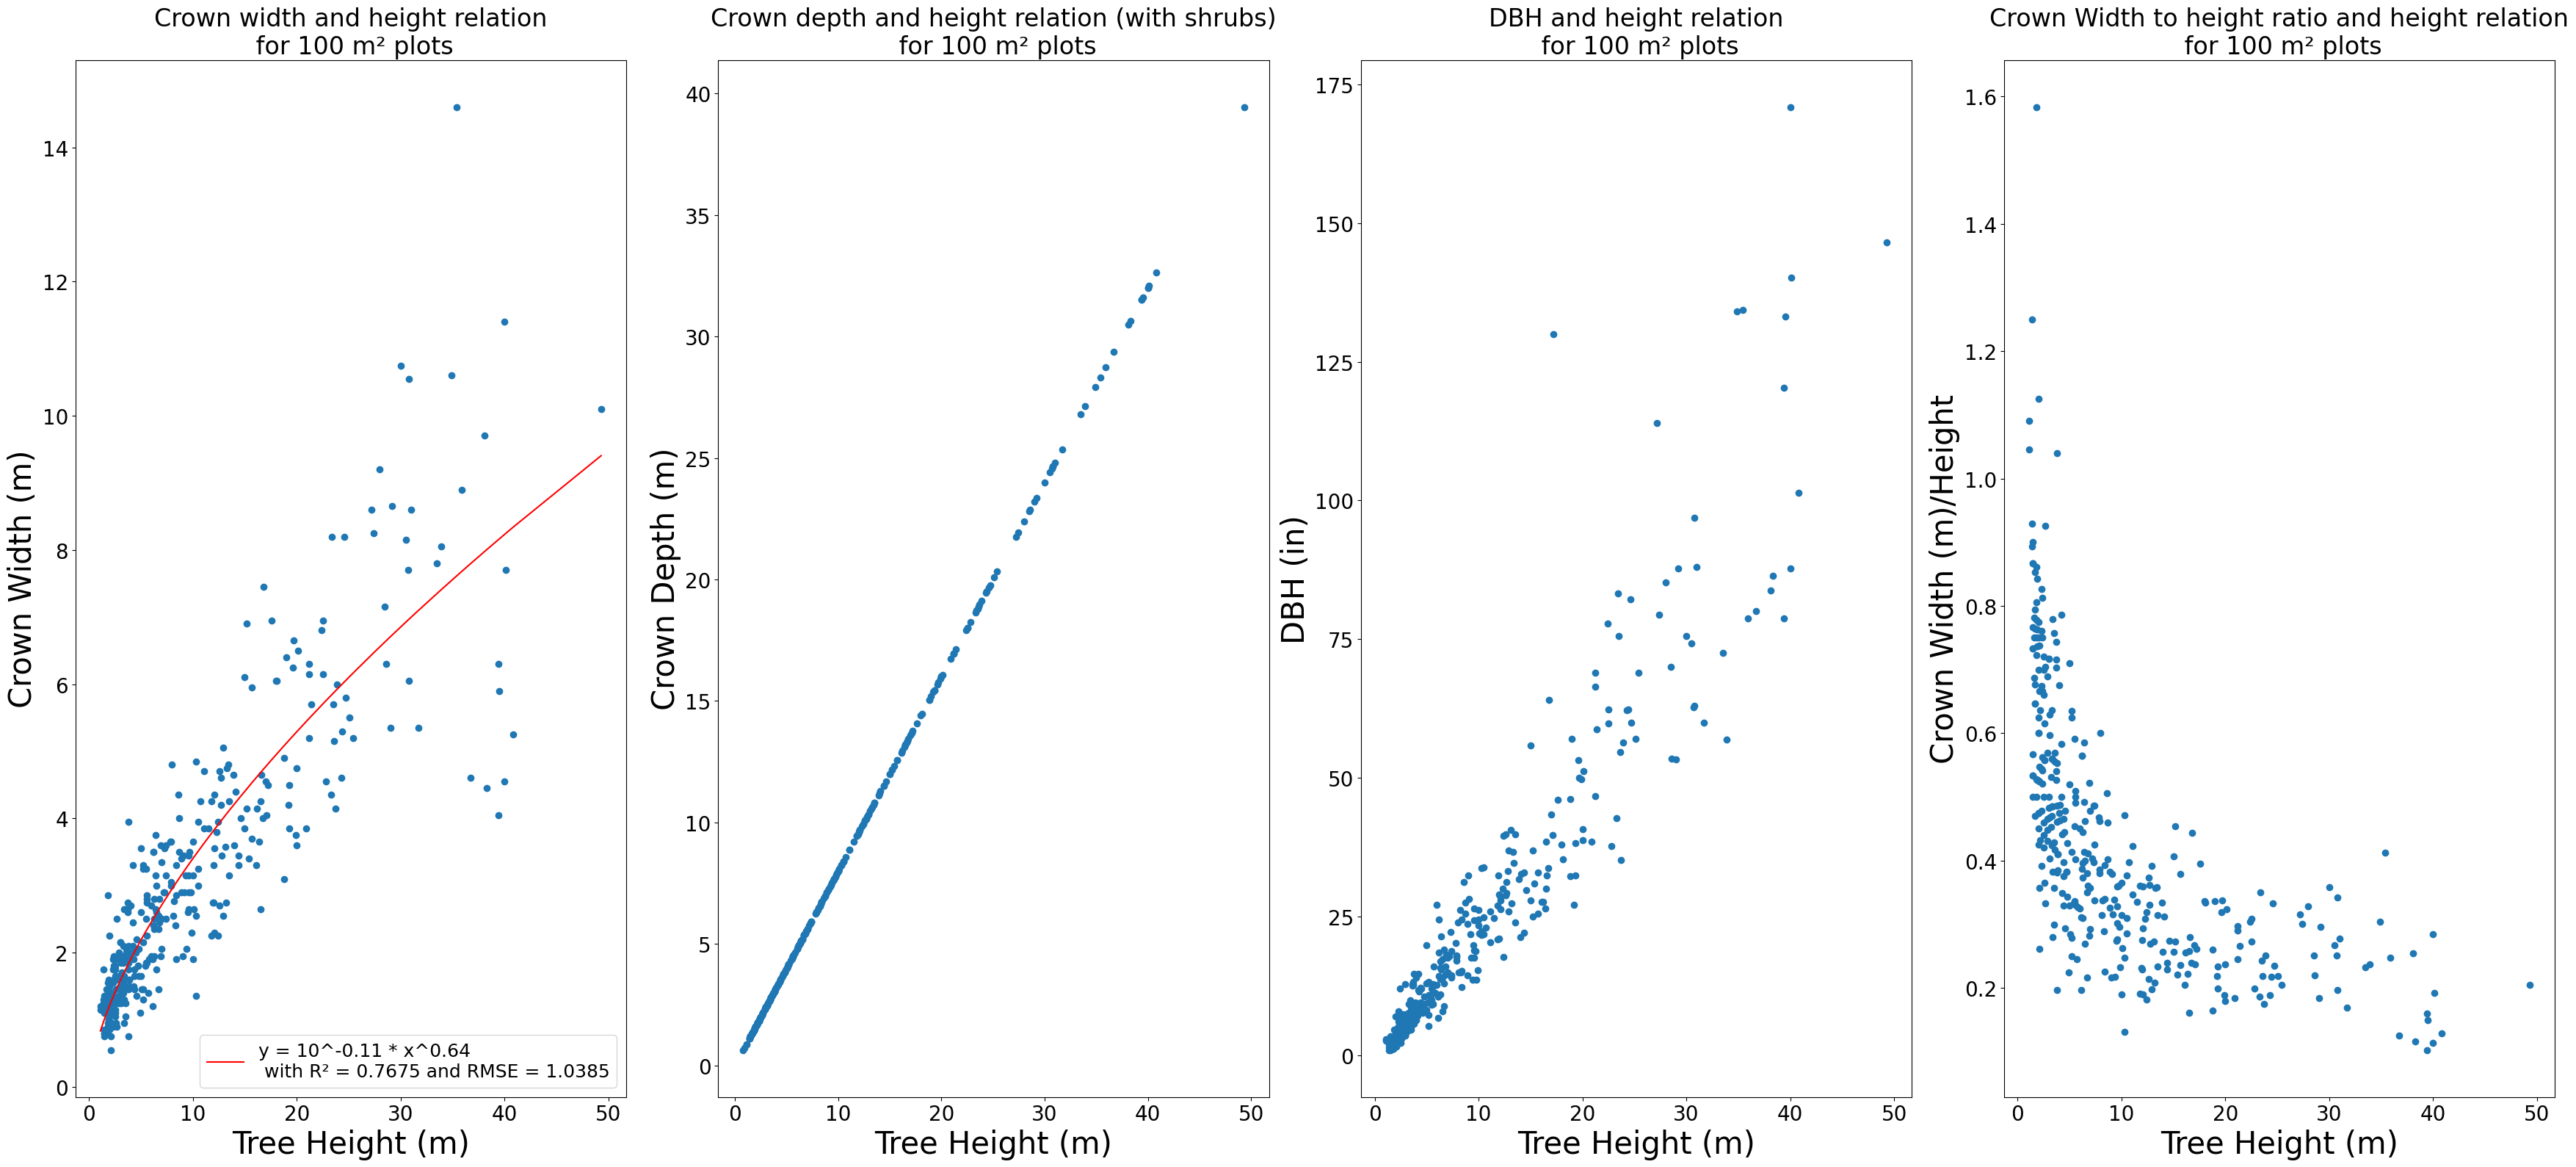

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

figs, axs = plt.subplots(1, 4, figsize = (35, 16))

noshrub_height_nona_100_df = noshrub_height_nona_100_df.sort_values(by='height')
x_existing, y_existing = noshrub_height_nona_100_df['height'], noshrub_height_nona_100_df['crown_width']

# Linear Regression Line
# m, b = np.polyfit(x1, y1, 1)
# mr = round(m, 2)
# br = round(b, 2)

# axs[0].plot(x1, m*x1 + b, color = 'red', label = f'(y = {mr}x + {br}) Regression Line')

# Quadratic Regression Line
# coefficients = np.polyfit(x1, y1, 2)
# a, b, c = coefficients

# x_curve = np.linspace(min(x1), max(x1), 100)
# y_curve = a * x_curve**2 + b* x_curve + c

# print(a, b, c)

# axs[0].plot(x_curve, y_curve, color = 'red', label = f'y = {round(a, 4)}x\u00B2 + {round(b, 2)}x + {round(c, 2)}')

# Exponential Regression Line
def exponential_func(x, a, b):
    return (10**a) * (x**b)

# Fit exponential regression model
popt, pcov = curve_fit(exponential_func, x_existing, y_existing)
a, b = popt

# Generate predicted values for x
y_pred  = exponential_func(x_existing, *popt)

# Calculate R2 and RMSE
r2 = r2_score(y_existing, y_pred)
rmse = np.sqrt(mean_squared_error(y_existing, y_pred))

print("R2 score for existing data:", r2)
print("RMSE for existing data:", rmse)

print(len(noshrub_height_nona_100_df))

# Row 1 Plot 1
axs[0].scatter(noshrub_height_nona_100_df['height'], noshrub_height_nona_100_df['crown_width'])
# axs[0].plot(x_new, y_pred_new, color = 'red', label = f"10^({c:.2f} * (x^{a:.2f})) Regression")
axs[0].plot(x_existing, y_pred, color = 'red', label = f"y = 10^{a:.2f} * x^{b:.2f} \n with R\u00B2 = {r2:.4f} and RMSE = {rmse:.4f}")
axs[0].set_title('Crown width and height relation\n for 100 m\u00B2 plots')
axs[0].set_xlabel('Tree Height (m)')
axs[0].set_ylabel('Crown Width (m)')
axs[0].legend(fontsize = '18')

# Row 1 Plot 2
axs[1].scatter(shrub_height_nona_100_df['height'], shrub_height_nona_100_df['crown_depth'])
axs[1].set_title('Crown depth and height relation (with shrubs)\n for 100 m\u00B2 plots')
axs[1].set_xlabel('Tree Height (m)')
axs[1].set_ylabel('Crown Depth (m)')

# Row 1 Plot 3
axs[2].scatter(noshrub_stem_nona_100_df['height'], noshrub_stem_nona_100_df['stemDiameter'])
axs[2].set_title('DBH and height relation\n for 100 m\u00B2 plots')
axs[2].set_xlabel('Tree Height (m)')
axs[2].set_ylabel('DBH (in)')

# Row 1 Plot 4
axs[3].scatter(noshrub_height_nona_100_df['height'], noshrub_height_nona_100_df['crown_width/h'])
axs[3].set_title('Crown Width to height ratio and height relation\n for 100 m\u00B2 plots')
axs[3].set_xlabel('Tree Height (m)')
axs[3].set_ylabel('Crown Width (m)/Height')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.tight_layout()

plt.savefig(root_path + 'TEAK_100_height_relations.png')
plt.show()

R2 score for existing data: 0.6244514633369426
RMSE for existing data: 0.9864896356374597
285


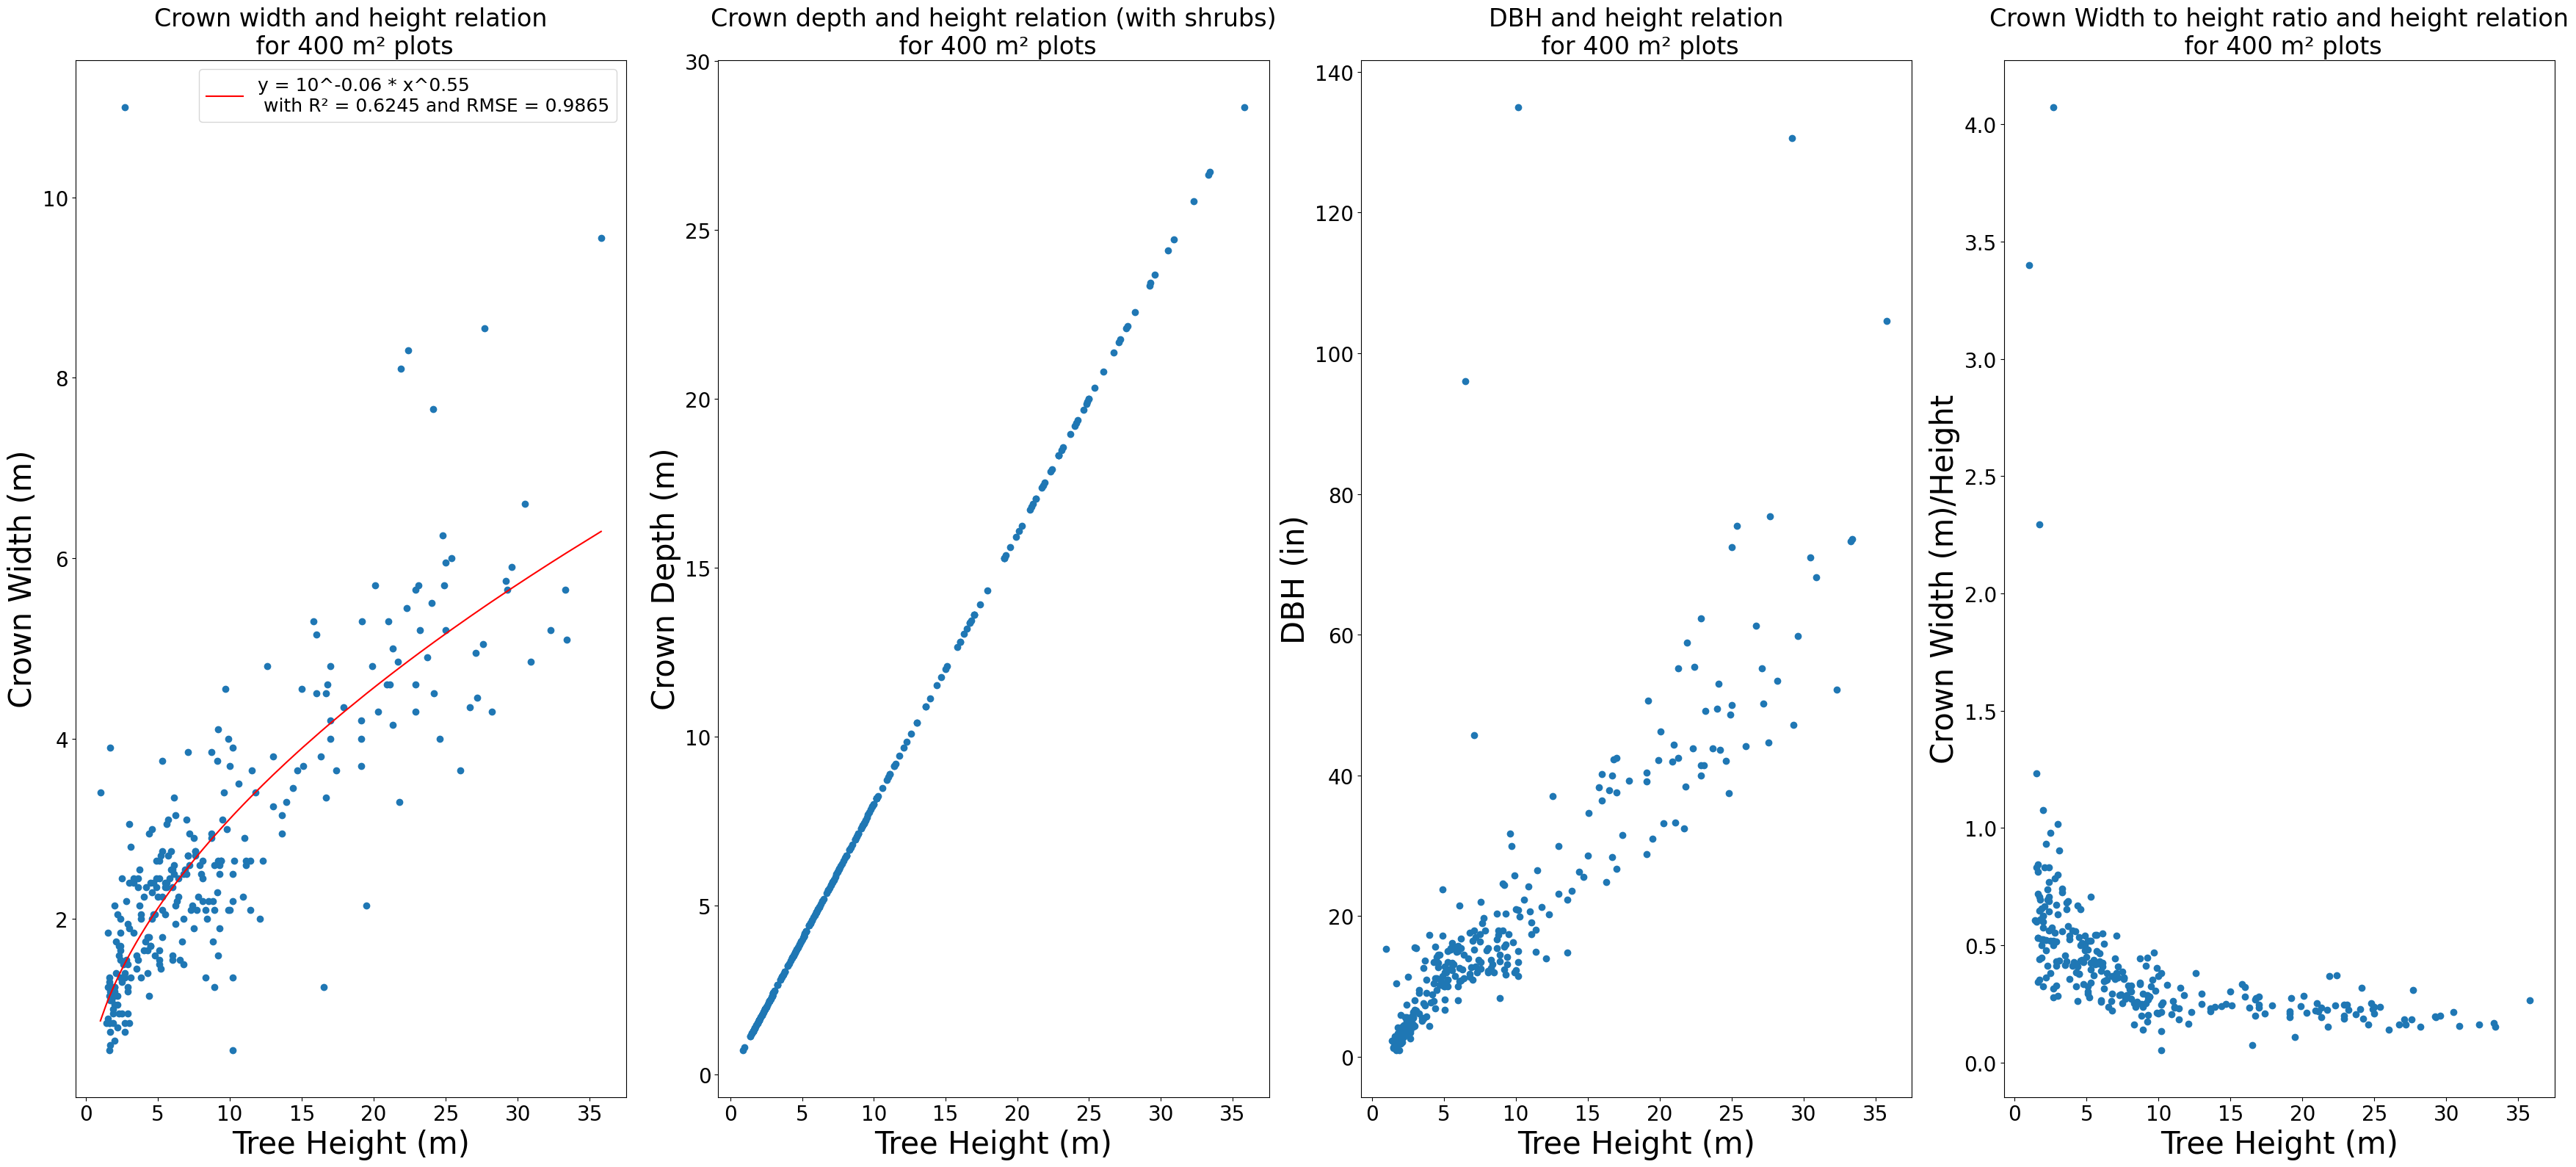

In [25]:
figs, axs = plt.subplots(1, 4, figsize = (35, 16))

noshrub_height_nona_400_df = noshrub_height_nona_400_df.sort_values(by='height')
x_existing, y_existing = noshrub_height_nona_400_df['height'], noshrub_height_nona_400_df['crown_width']

# Exponential Regression Line
def exponential_func(x, a, b):
    return (10**a) * (x**b)

# Fit exponential regression model
popt, pcov = curve_fit(exponential_func, x_existing, y_existing)
a, b = popt

# Generate predicted values for x
y_pred  = exponential_func(x_existing, *popt)

# Calculate R2 and RMSE
r2 = r2_score(y_existing, y_pred)
rmse = np.sqrt(mean_squared_error(y_existing, y_pred))

print("R2 score for existing data:", r2)
print("RMSE for existing data:", rmse)

print(len(noshrub_height_nona_400_df))

# Row 1 Plot 1
axs[0].scatter(noshrub_height_nona_400_df['height'], noshrub_height_nona_400_df['crown_width'])
# axs[0].plot(x_new, y_pred_new, color = 'red', label = f"10^({c:.2f} * (x^{a:.2f})) Regression")
axs[0].plot(x_existing, y_pred, color = 'red', label = f"y = 10^{a:.2f} * x^{b:.2f} \n with R\u00B2 = {r2:.4f} and RMSE = {rmse:.4f}")
axs[0].set_title('Crown width and height relation\n for 400 m\u00B2 plots')
axs[0].set_xlabel('Tree Height (m)')
axs[0].set_ylabel('Crown Width (m)')
axs[0].legend(fontsize = '18')

# Row 1 Plot 2
axs[1].scatter(shrub_height_nona_400_df['height'], shrub_height_nona_400_df['crown_depth'])
axs[1].set_title('Crown depth and height relation (with shrubs)\n for 400 m\u00B2 plots')
axs[1].set_xlabel('Tree Height (m)')
axs[1].set_ylabel('Crown Depth (m)')

# Row 1 Plot 3
axs[2].scatter(noshrub_height_nona_400_df['height'], noshrub_height_nona_400_df['stemDiameter'])
axs[2].set_title('DBH and height relation\n for 400 m\u00B2 plots')
axs[2].set_xlabel('Tree Height (m)')
axs[2].set_ylabel('DBH (in)')

# Row 1 Plot 4
axs[3].scatter(noshrub_height_nona_400_df['height'], noshrub_height_nona_400_df['crown_width/h'])
axs[3].set_title('Crown Width to height ratio and height relation\n for 400 m\u00B2 plots')
axs[3].set_xlabel('Tree Height (m)')
axs[3].set_ylabel('Crown Width (m)/Height')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.tight_layout()

plt.savefig(root_path + 'TEAK_400_height_relations.png')
plt.show()

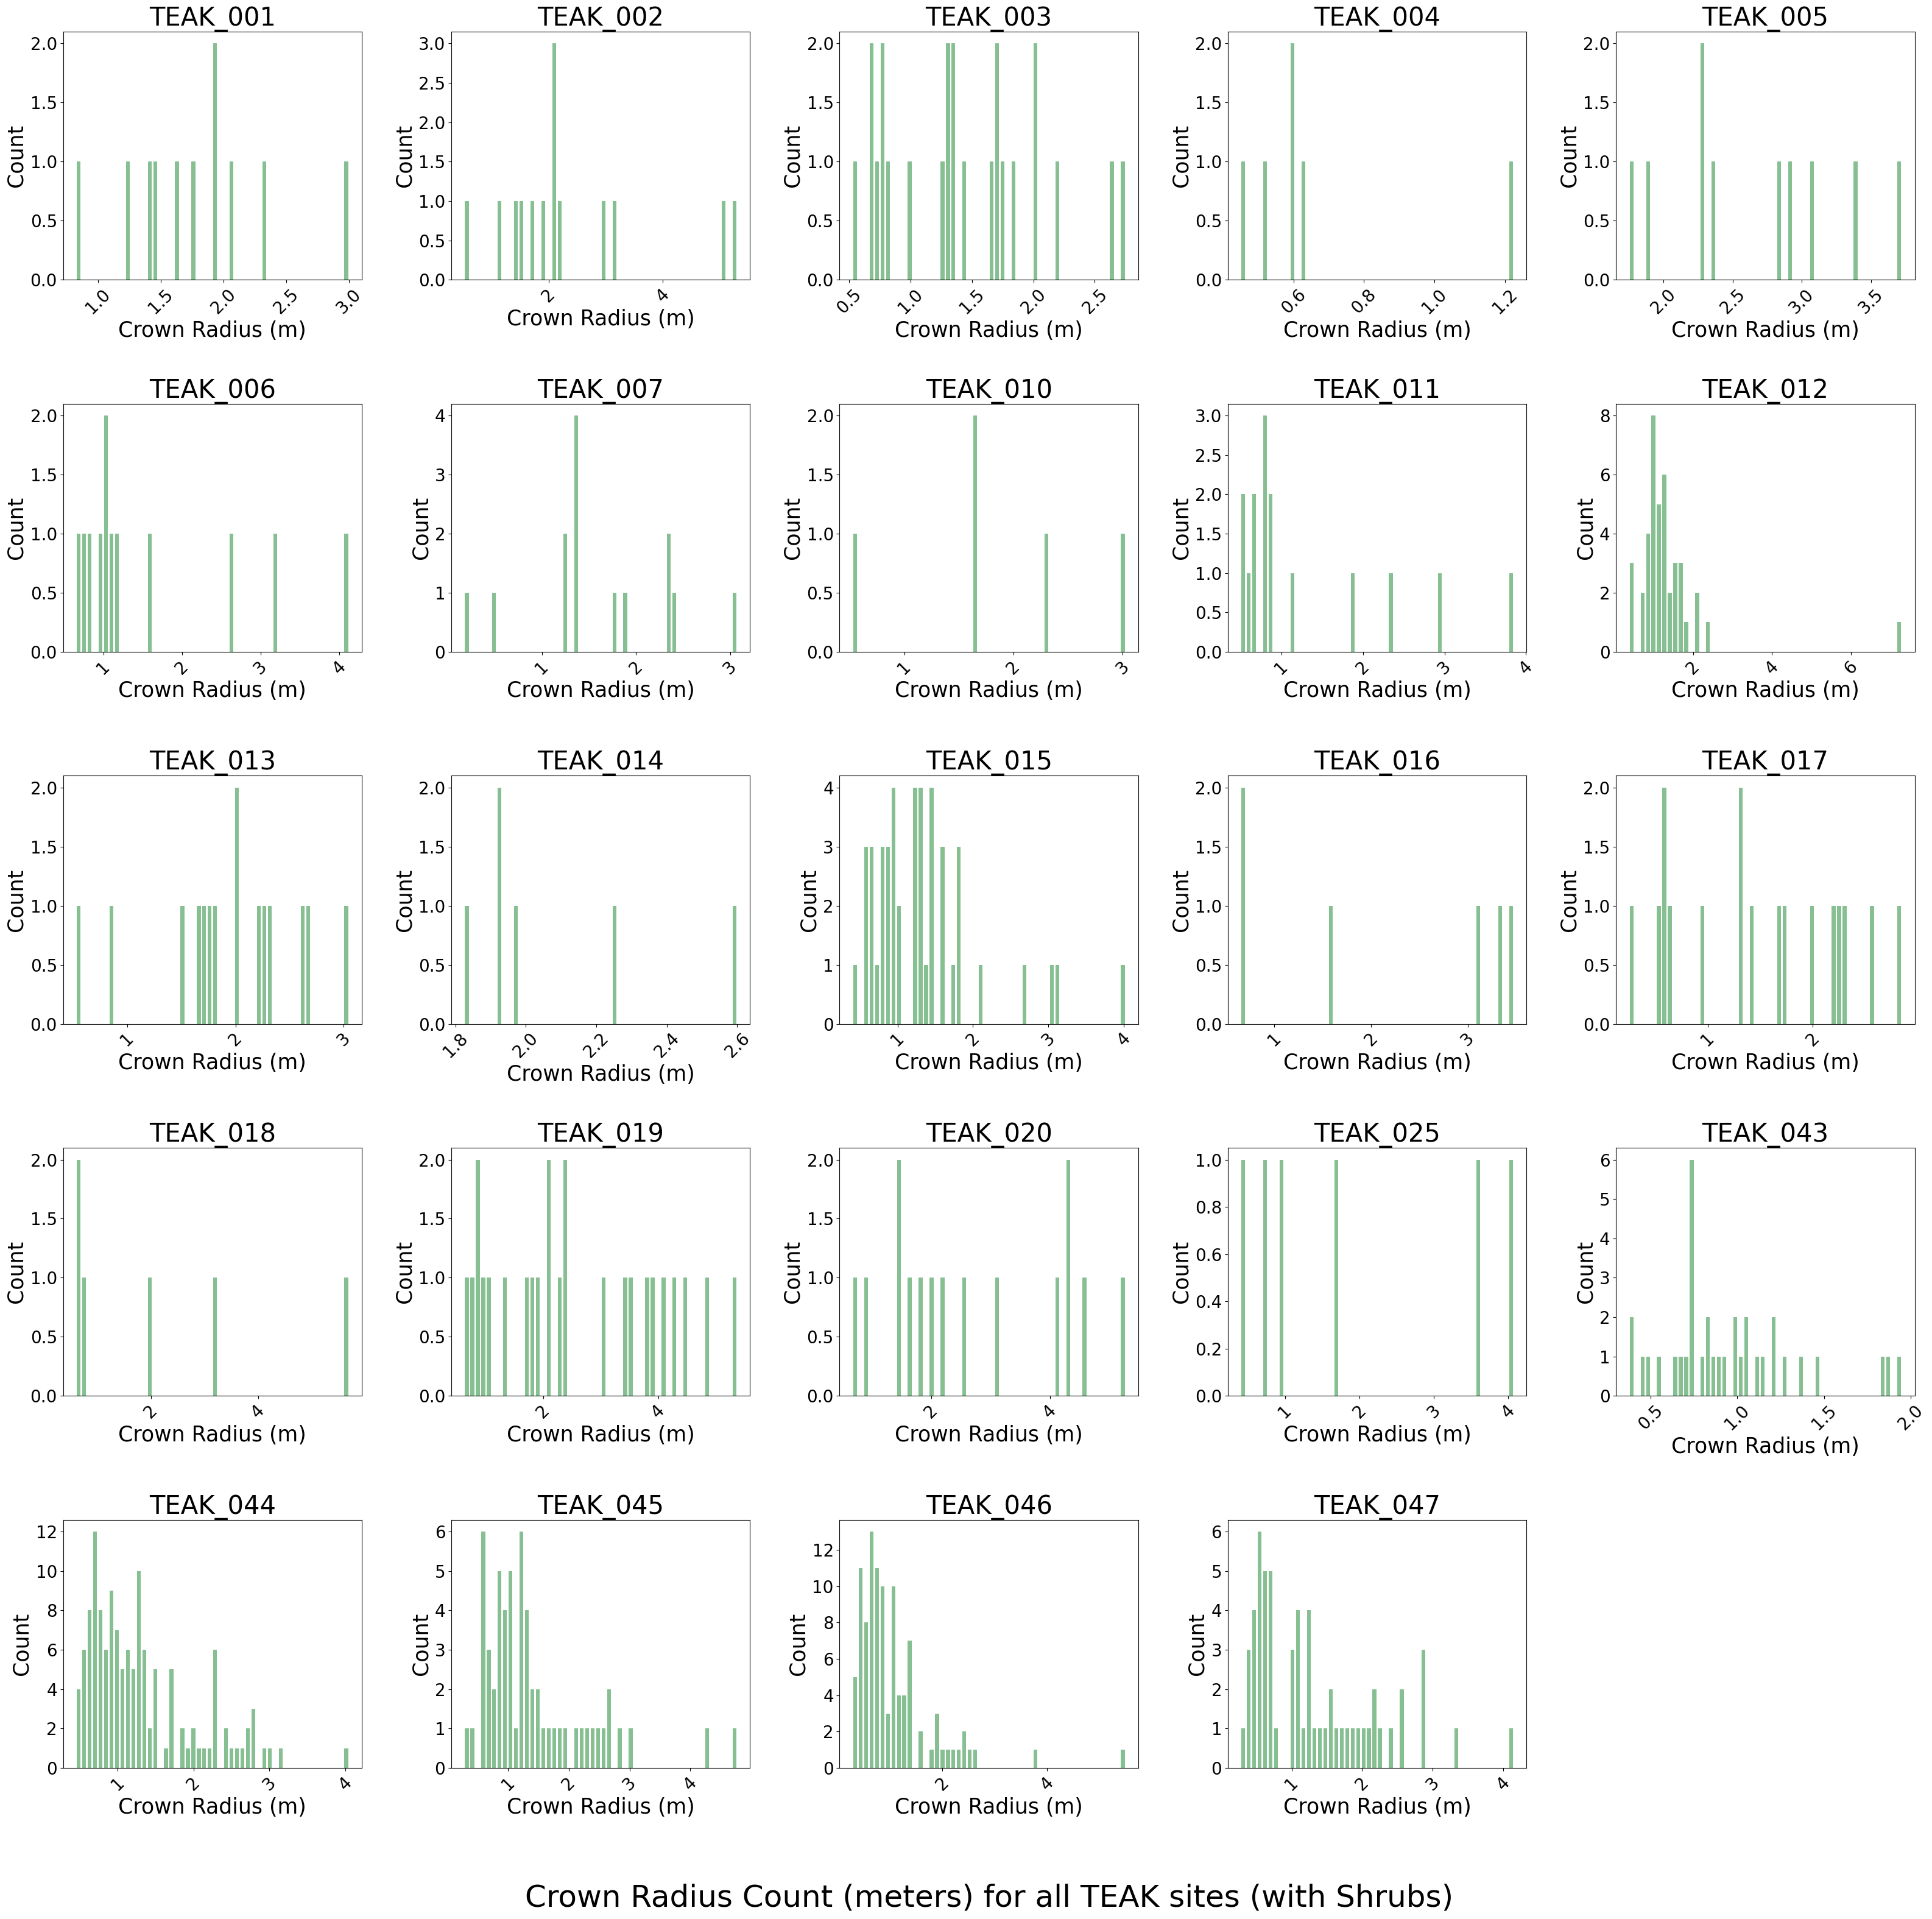

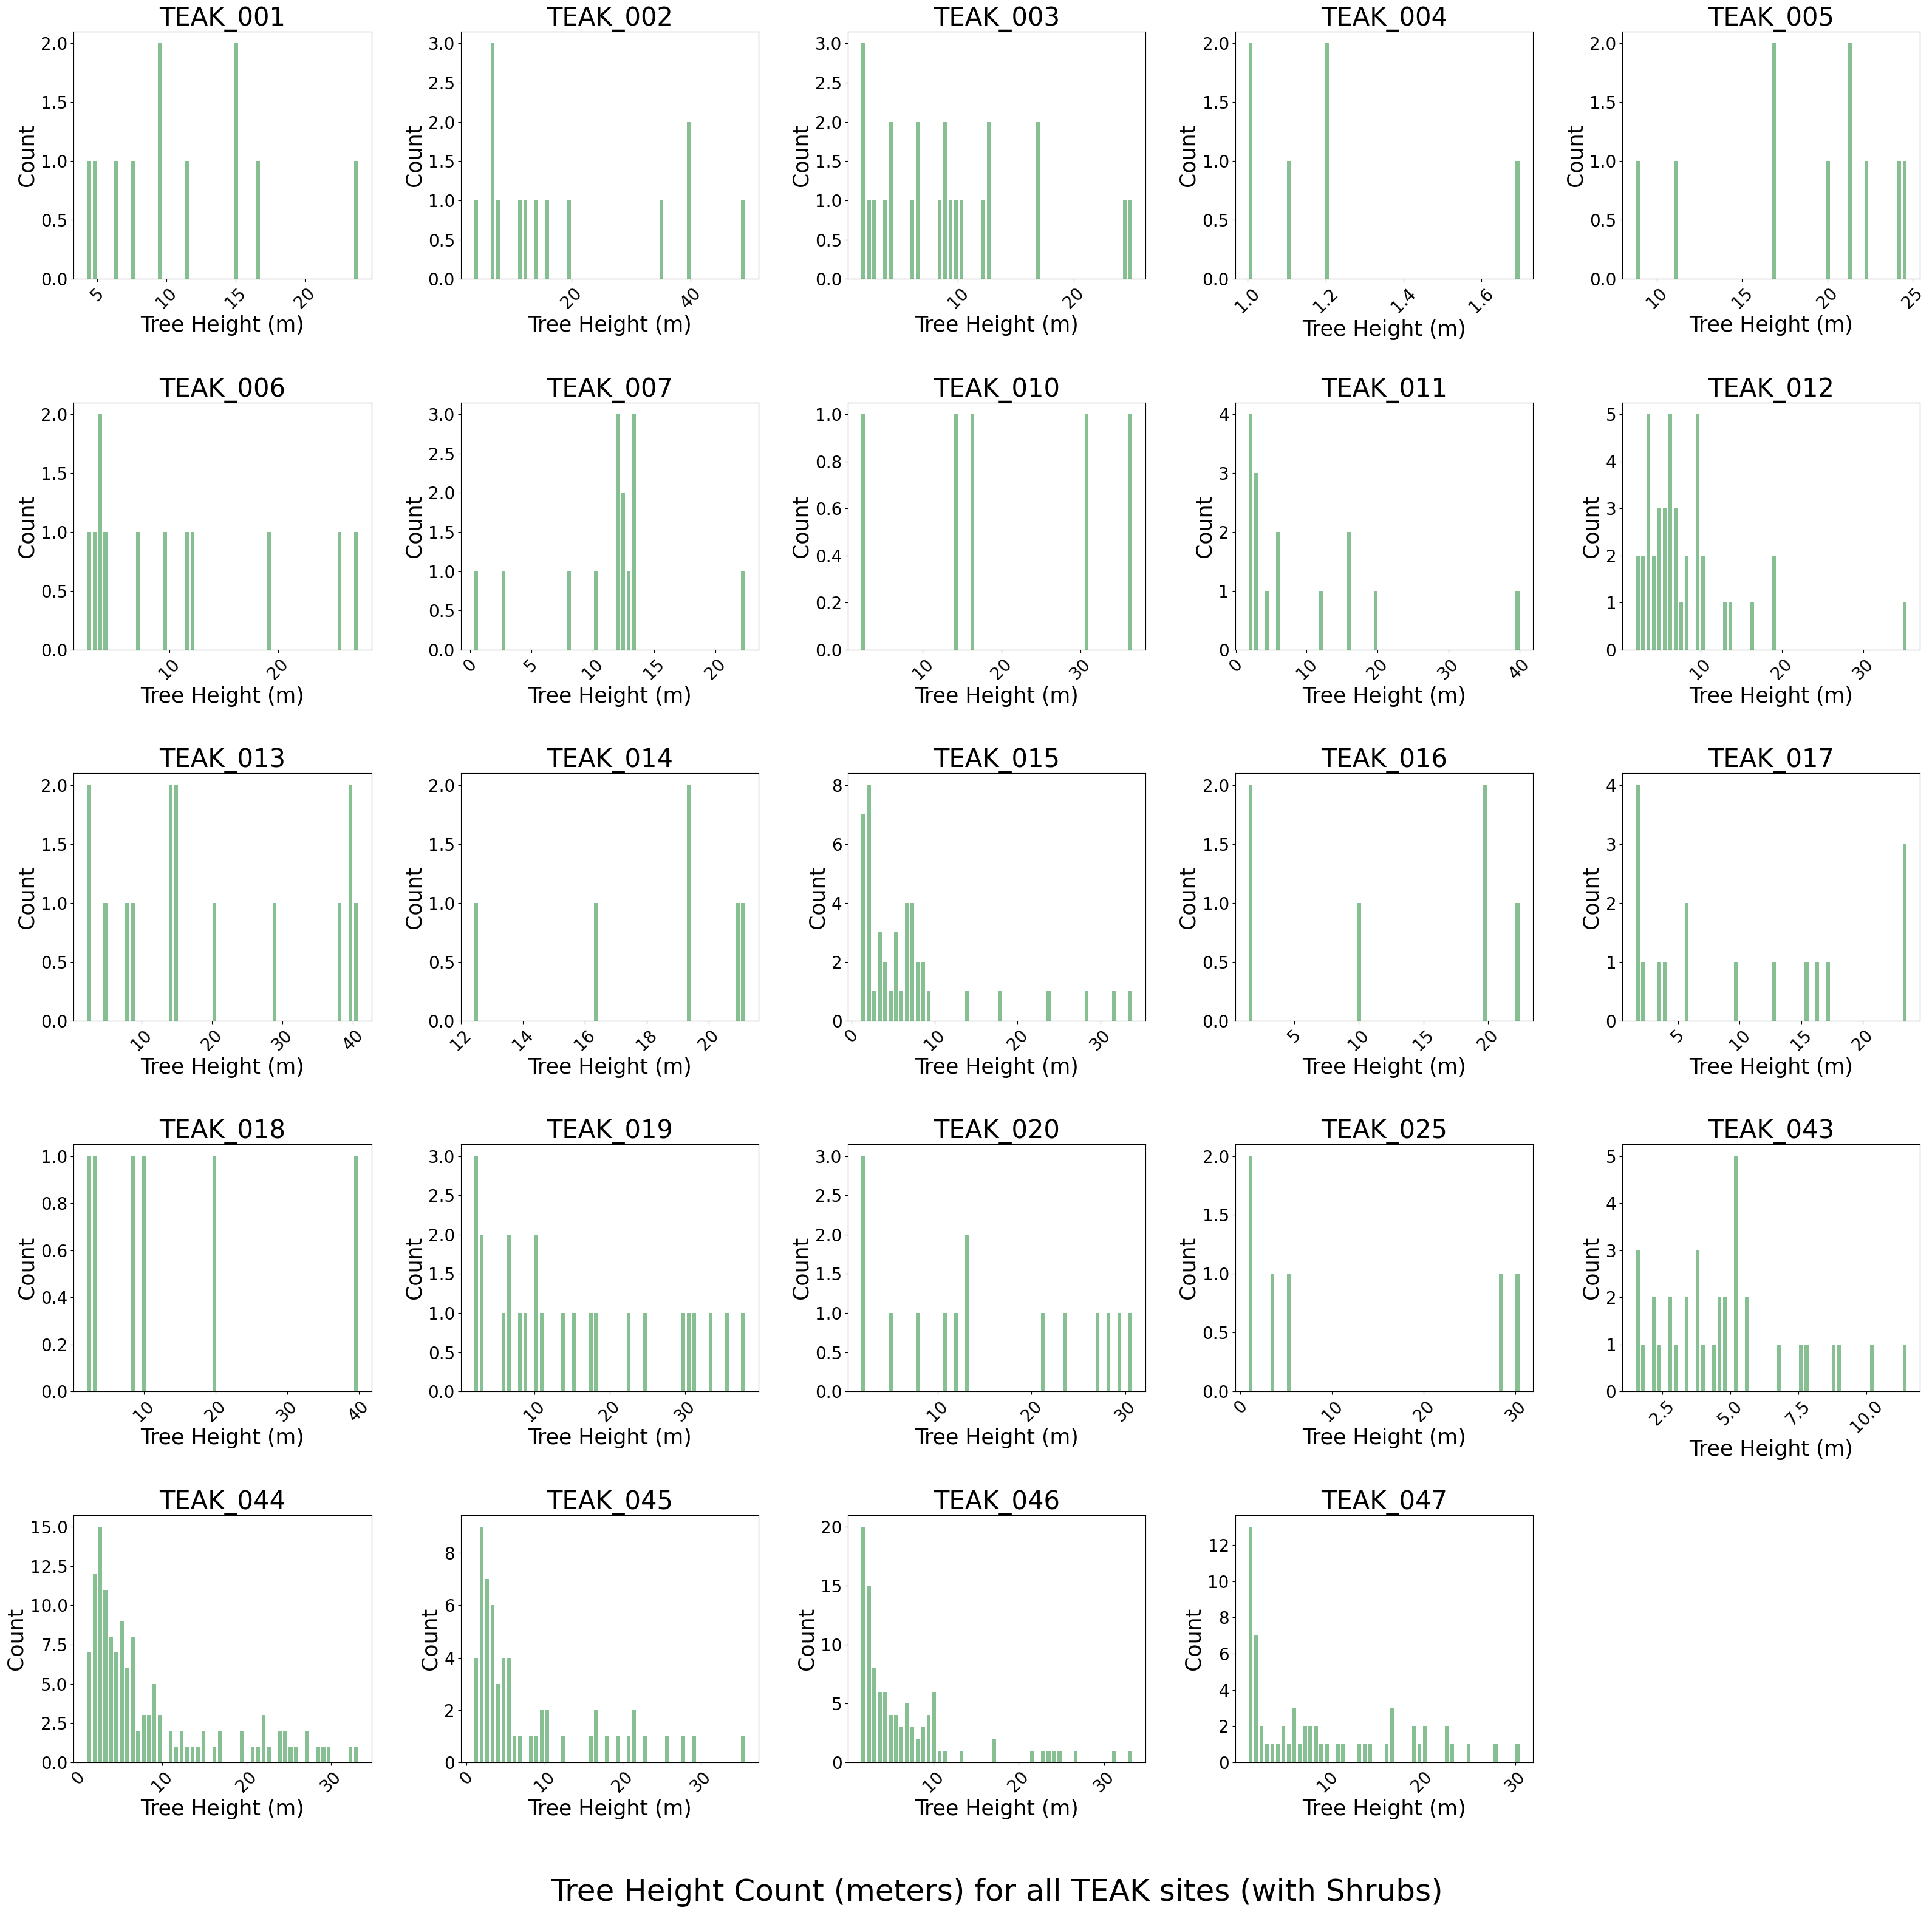

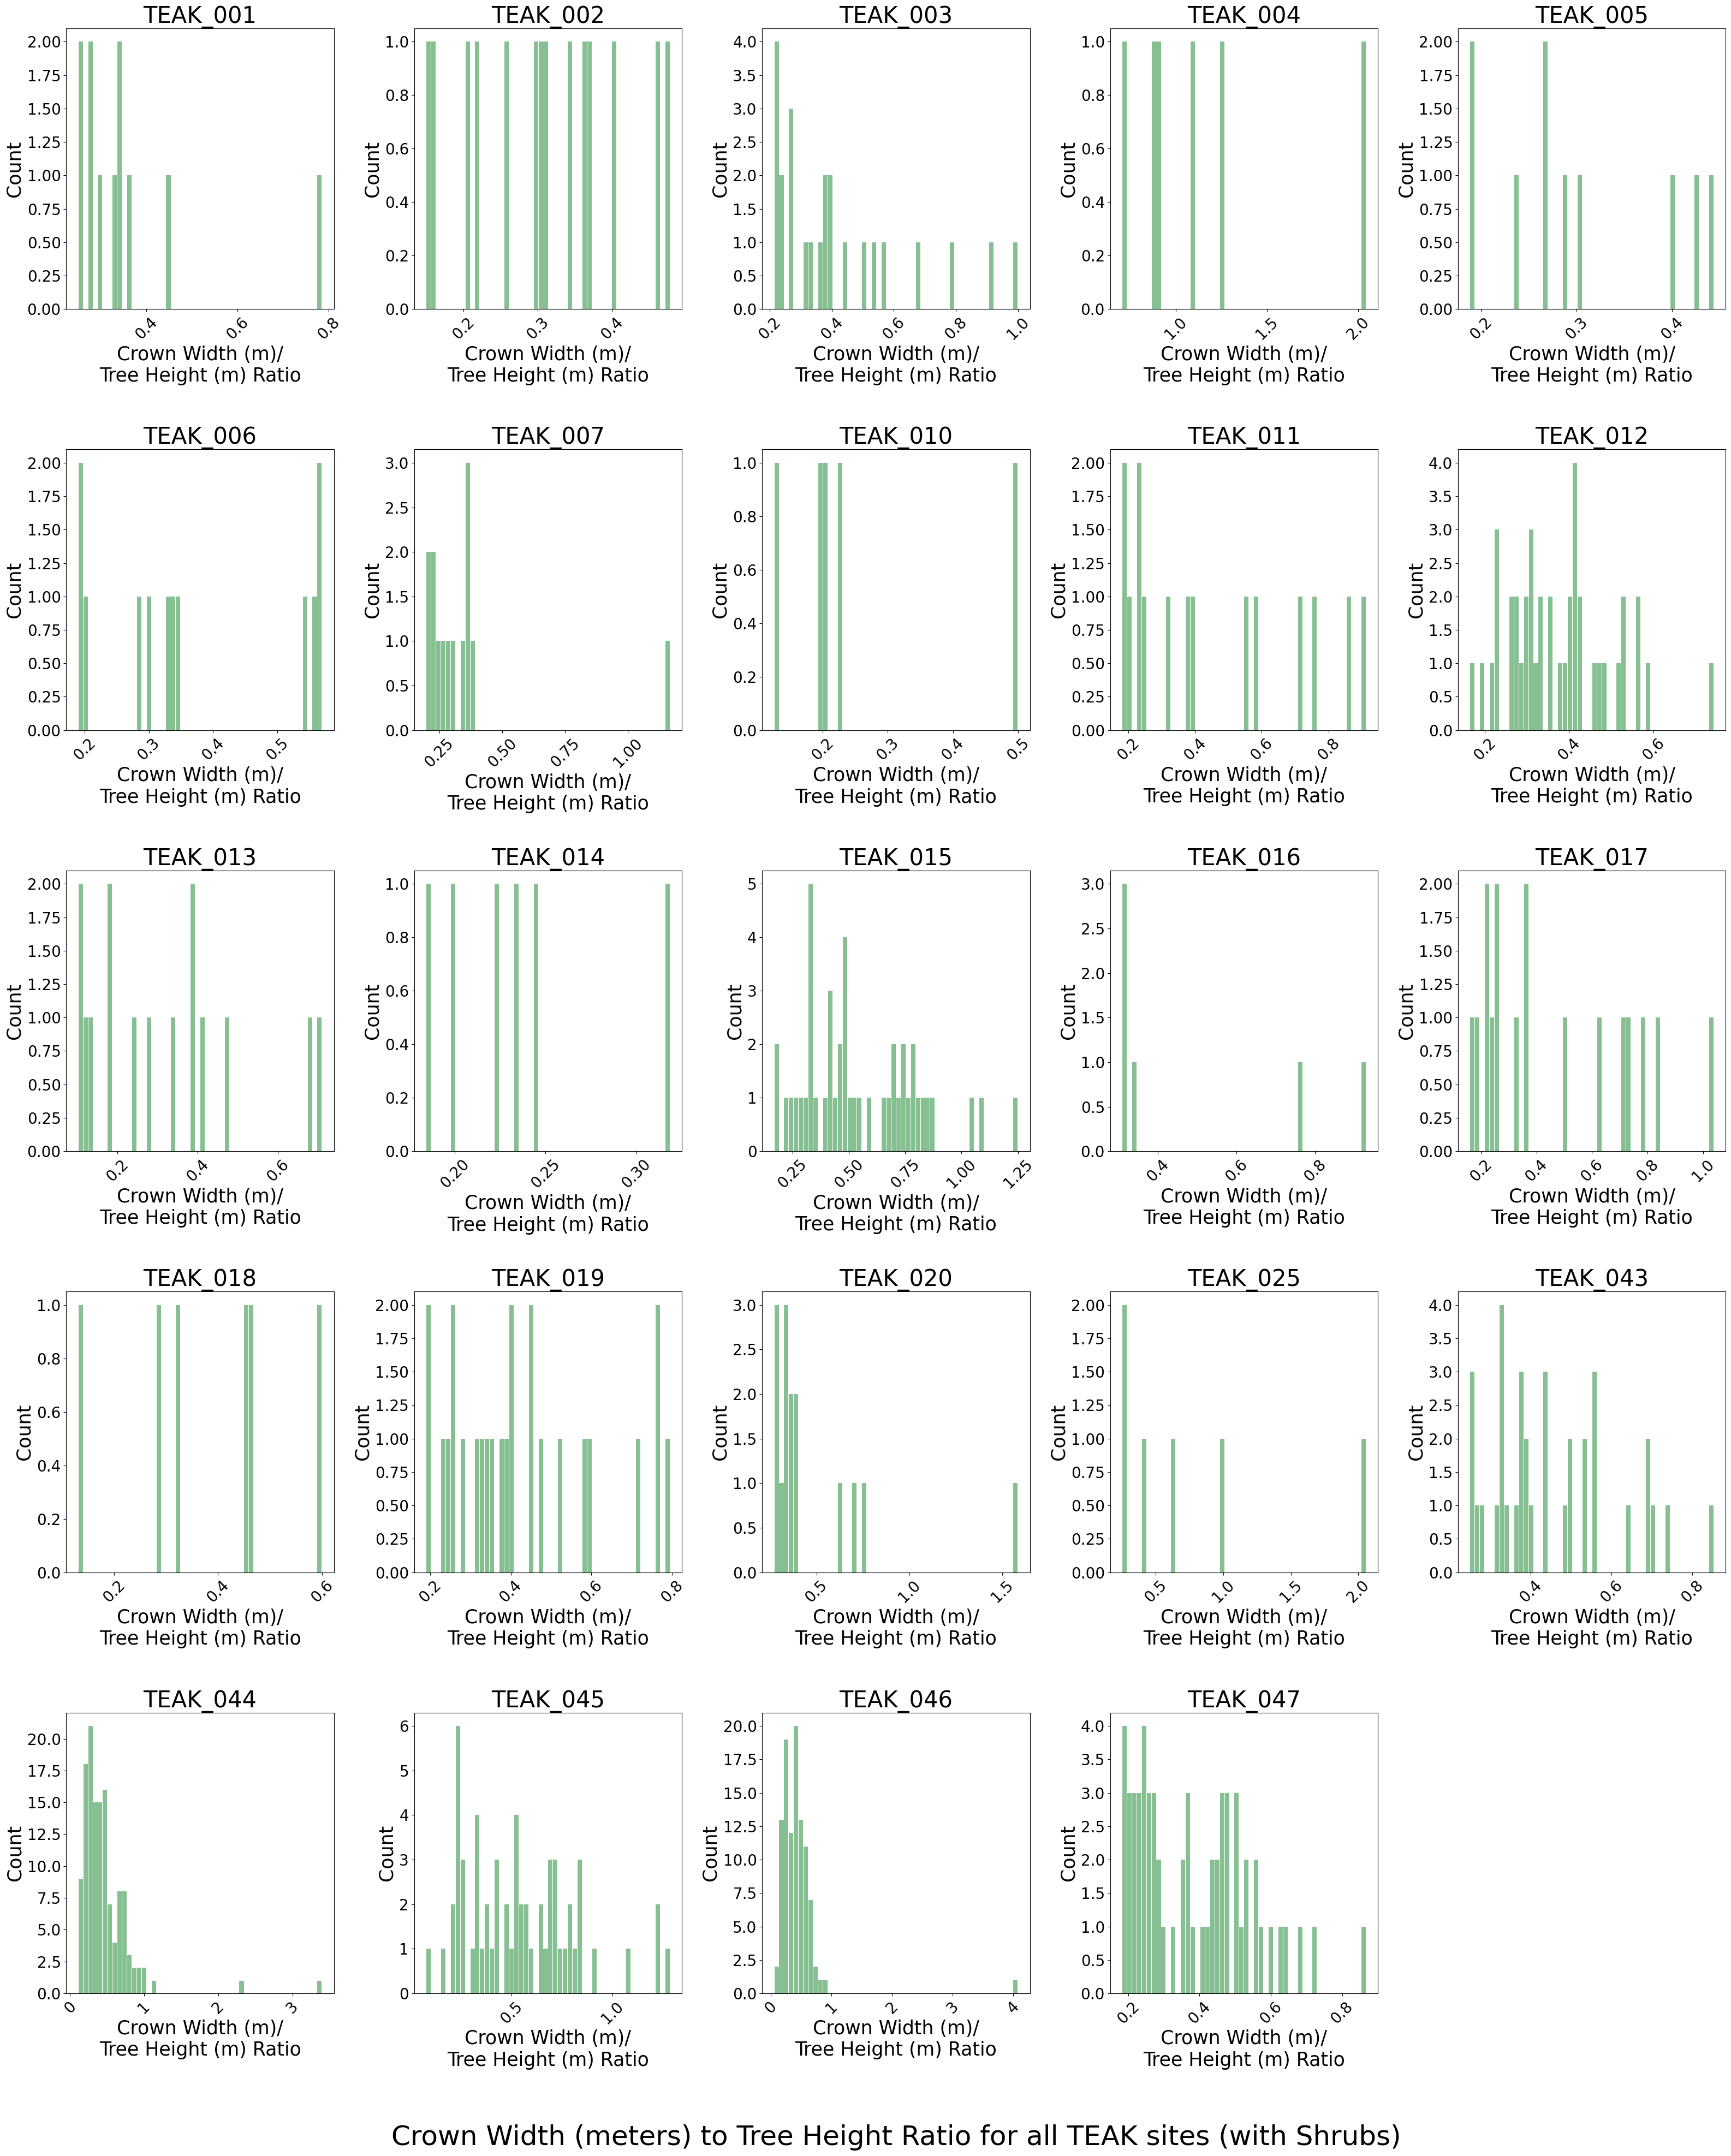

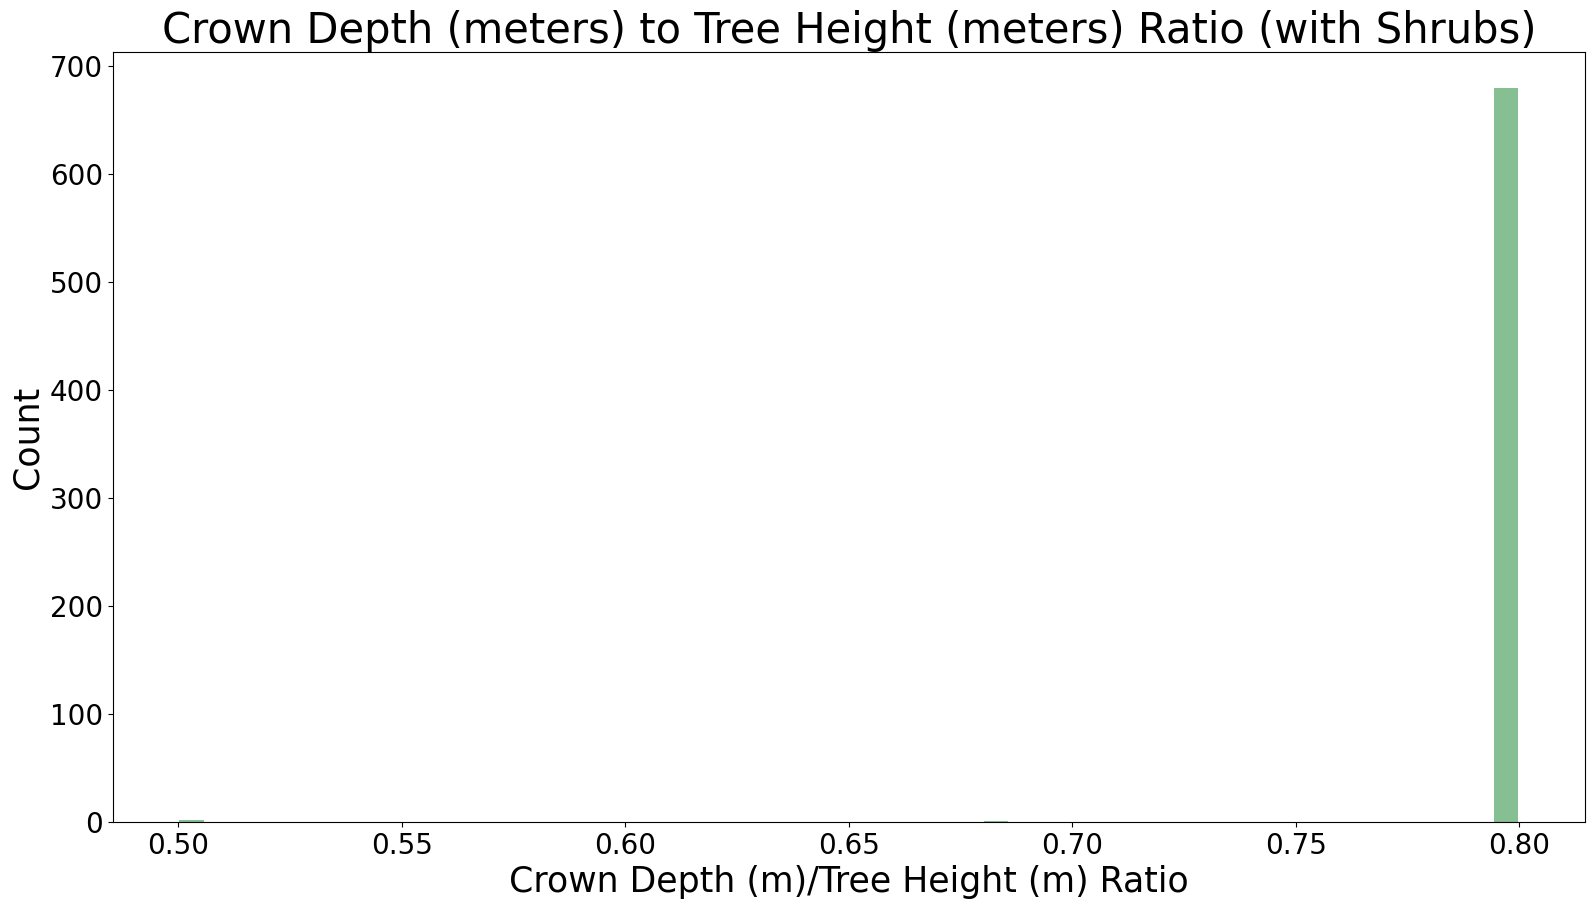

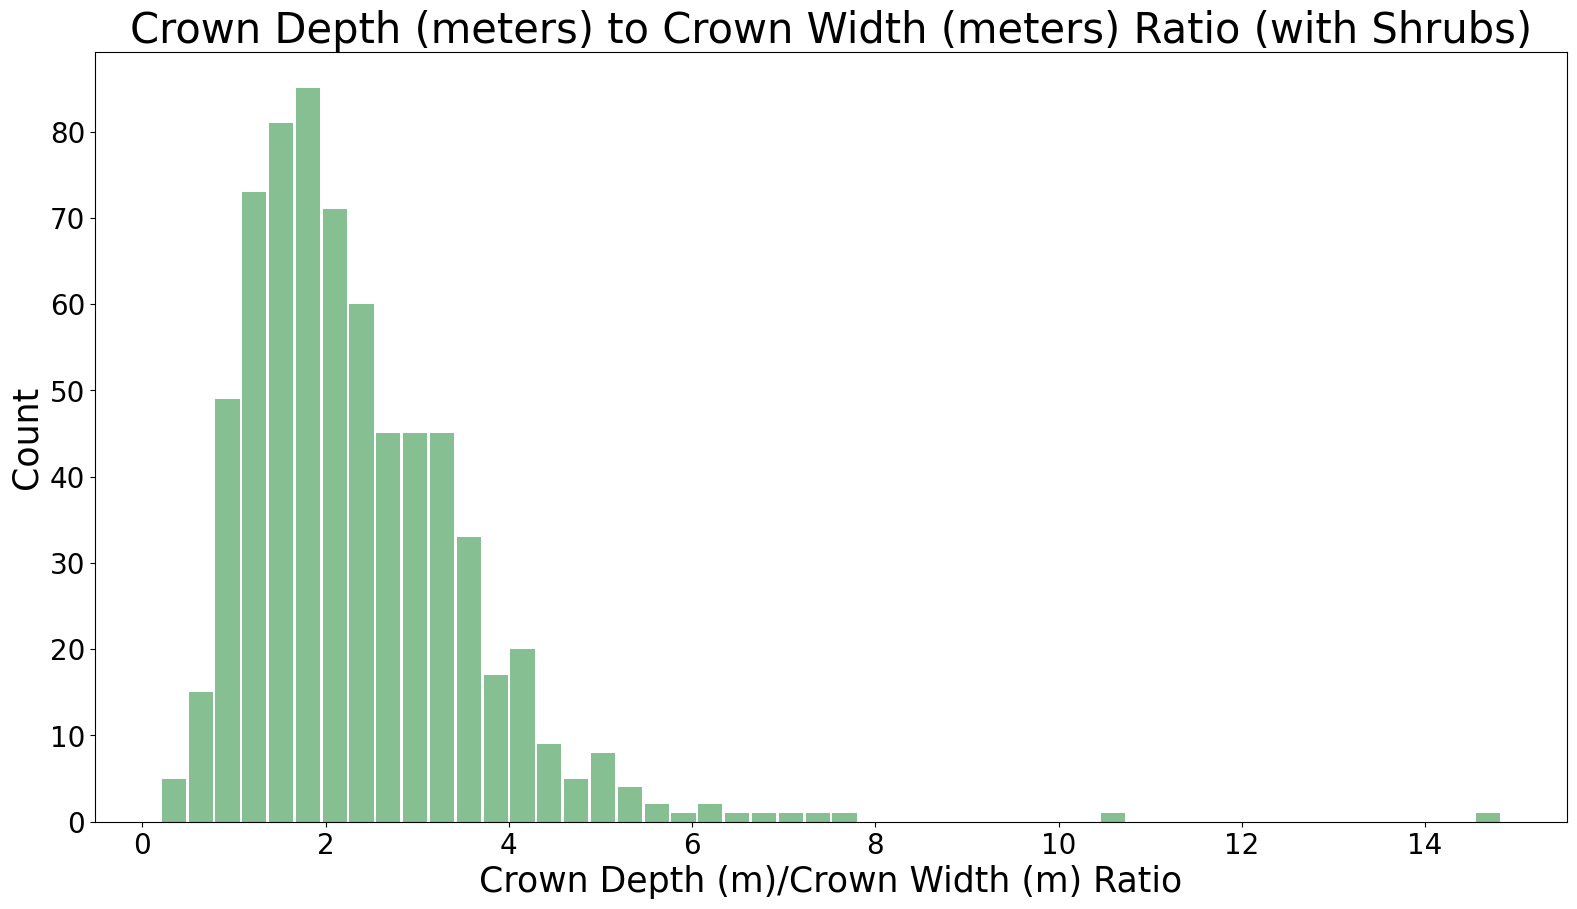

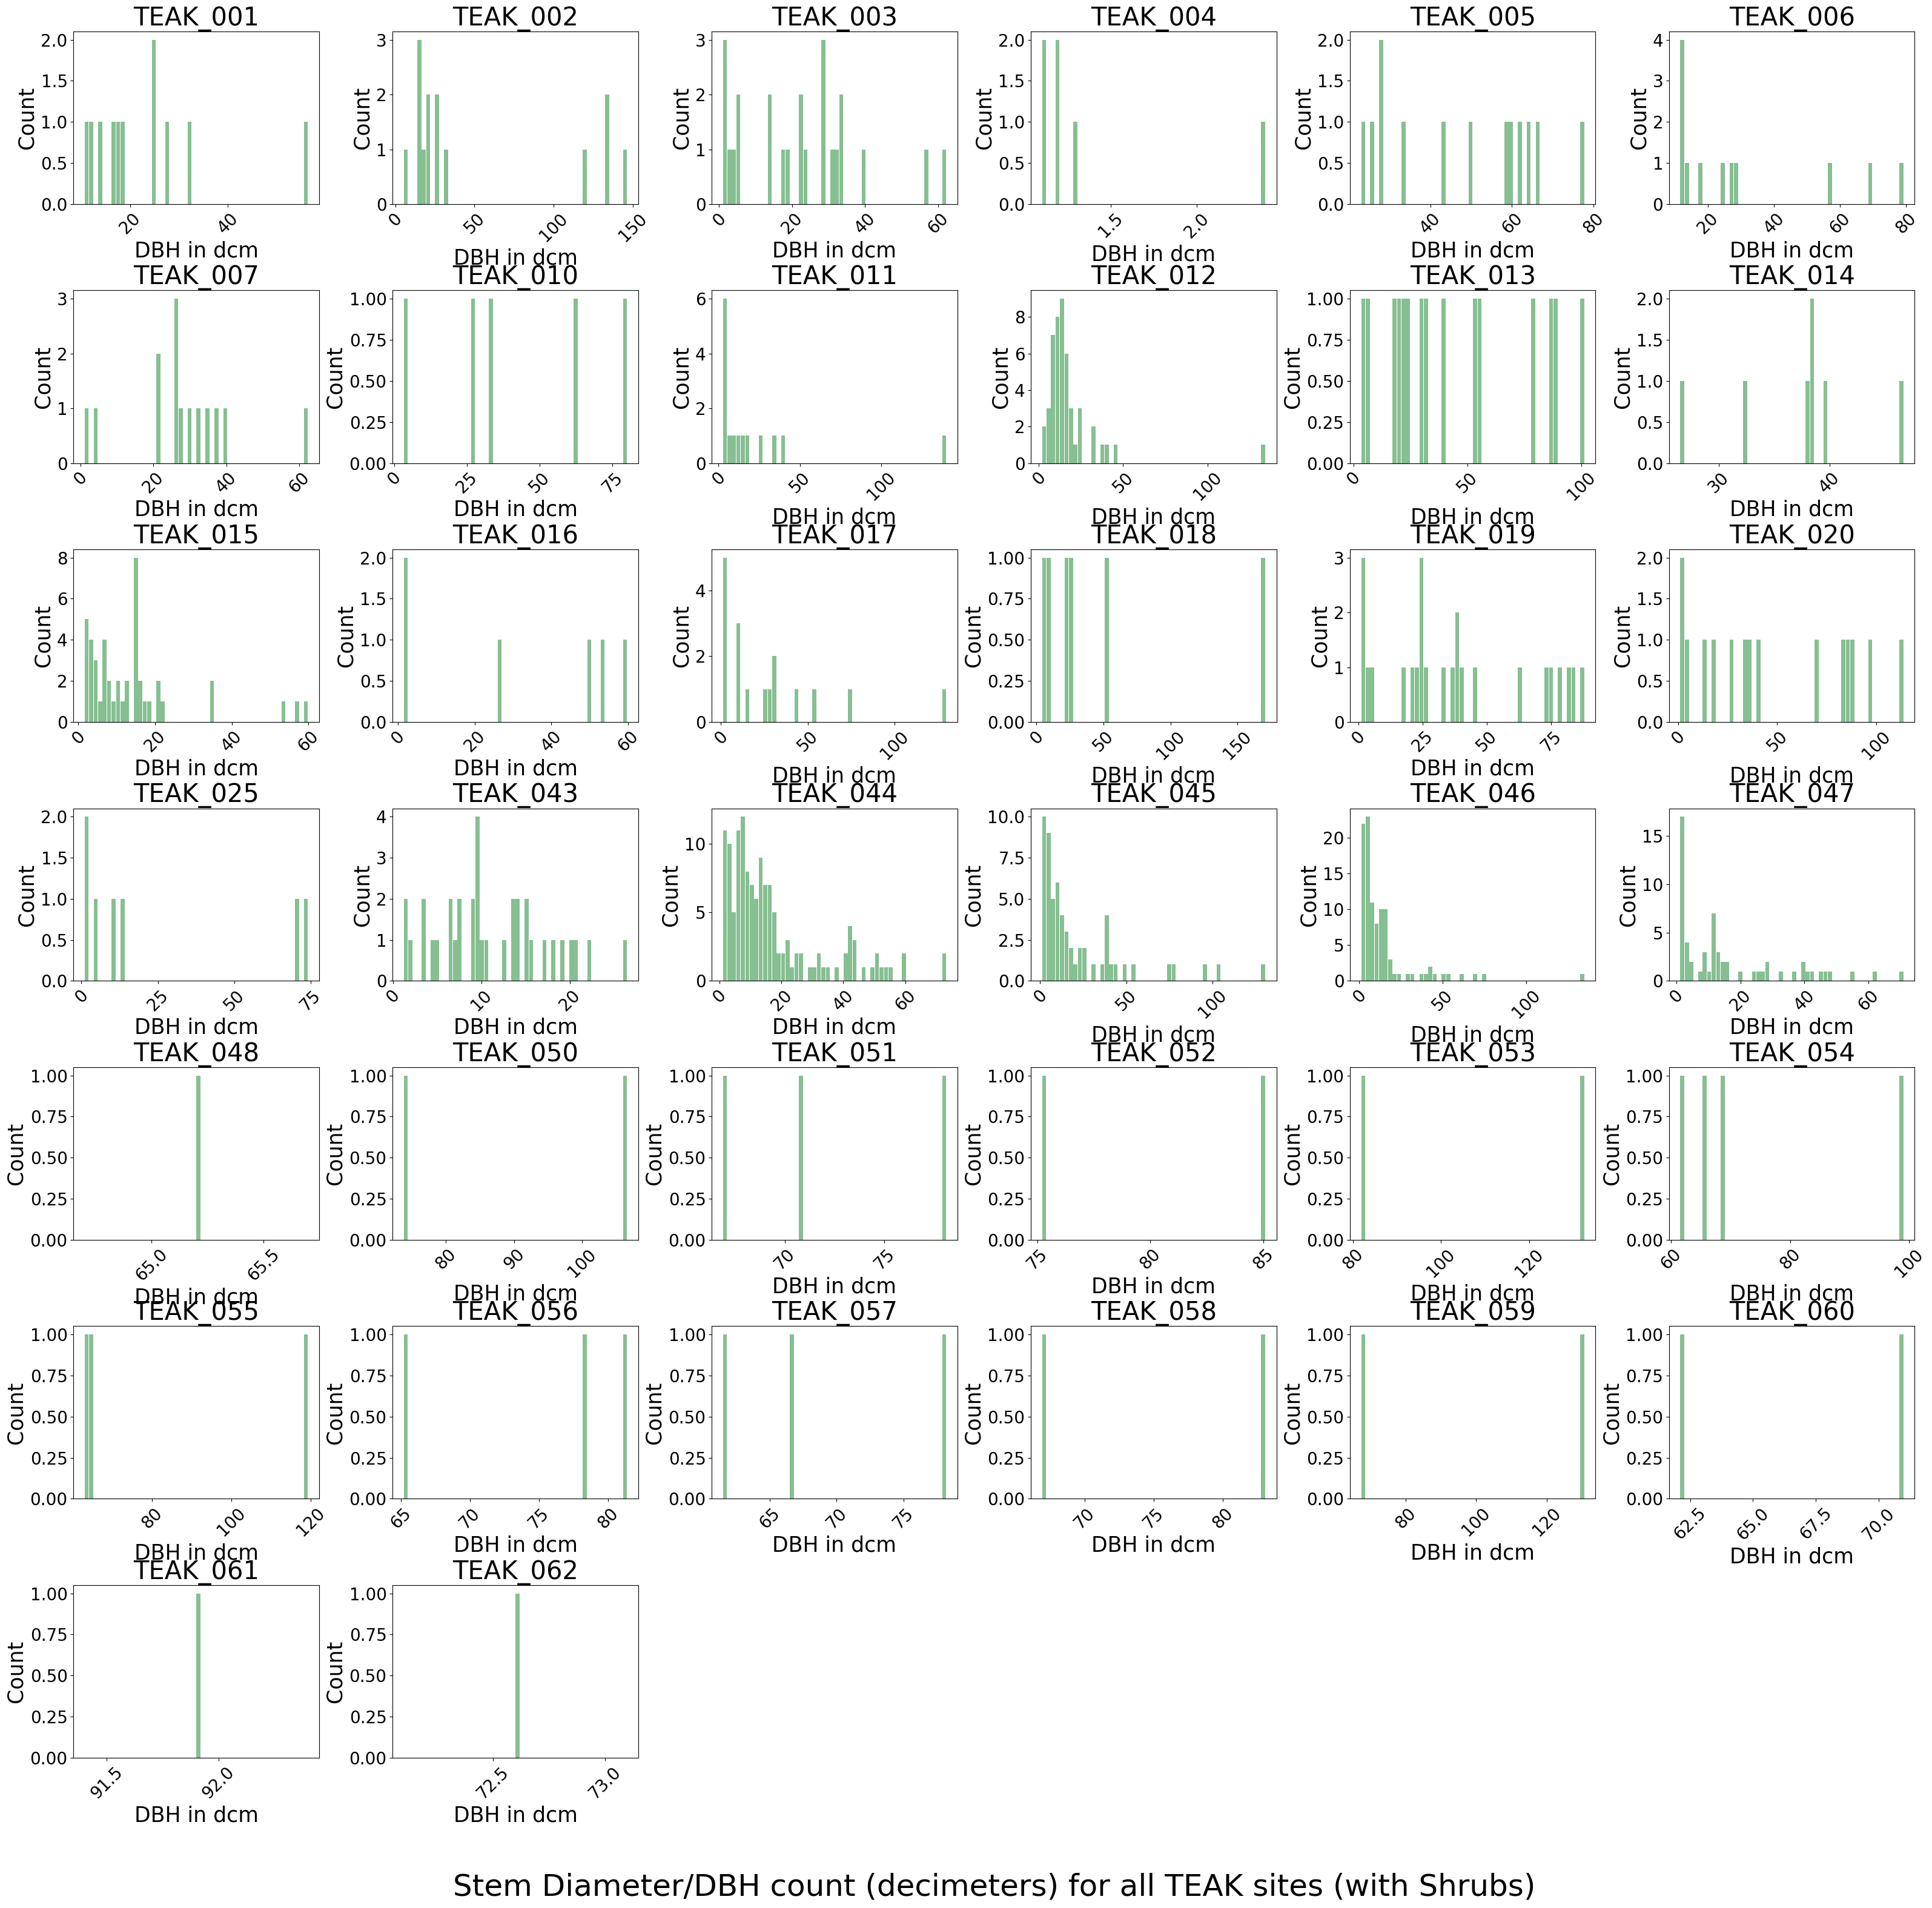

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# begin plots with shrub and save to file
ax = shrub_height_nona_df.hist(column = 'crown_radius', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('Crown Radius (m)', fontsize=25)

# subplot_TEAK_0043_21
# for ax_y in ax:
#     for ax_x in ax_y:
#         ax_x.set_ylabel('Count')
#         ax_x.set_xlabel('Crown Radius (m)')

plt.suptitle('Crown Radius Count (meters) for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_radius.png')

ax = shrub_height_nona_df.hist(column = 'height', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('Tree Height (m)', fontsize=25)

plt.suptitle('Tree Height Count (meters) for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_height.png')

ax = shrub_height_nona_df.hist(column = 'crown_width/h', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,48), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('Crown Width (m)/\nTree Height (m) Ratio', fontsize=25)

plt.suptitle('Crown Width (meters) to Tree Height Ratio for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_width_height_ratio.png')

ax = shrub_height_nona_df.hist(column = 'crown_depth/h', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

ax[0][0].set_ylabel('Count', fontsize=25)
ax[0][0].set_xlabel('Crown Depth (m)/Tree Height (m) Ratio', fontsize=25)

plt.title('Crown Depth (meters) to Tree Height (meters) Ratio (with Shrubs)')
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_depth_height_ratio.png')

ax = shrub_height_nona_df.hist(column = 'crown_depth/crown_width', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

ax[0][0].set_ylabel('Count', fontsize=25)
ax[0][0].set_xlabel('Crown Depth (m)/Crown Width (m) Ratio', fontsize=25)

plt.title('Crown Depth (meters) to Crown Width (meters) Ratio (with Shrubs)')
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_depth_crown_width_ratio.png')

ax = shrub_stem_nona_df.hist(column = 'stemDiameter', by = shrub_stem_nona_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('DBH in dcm', fontsize=25)

plt.suptitle('Stem Diameter/DBH count (decimeters) for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_DBH.png')

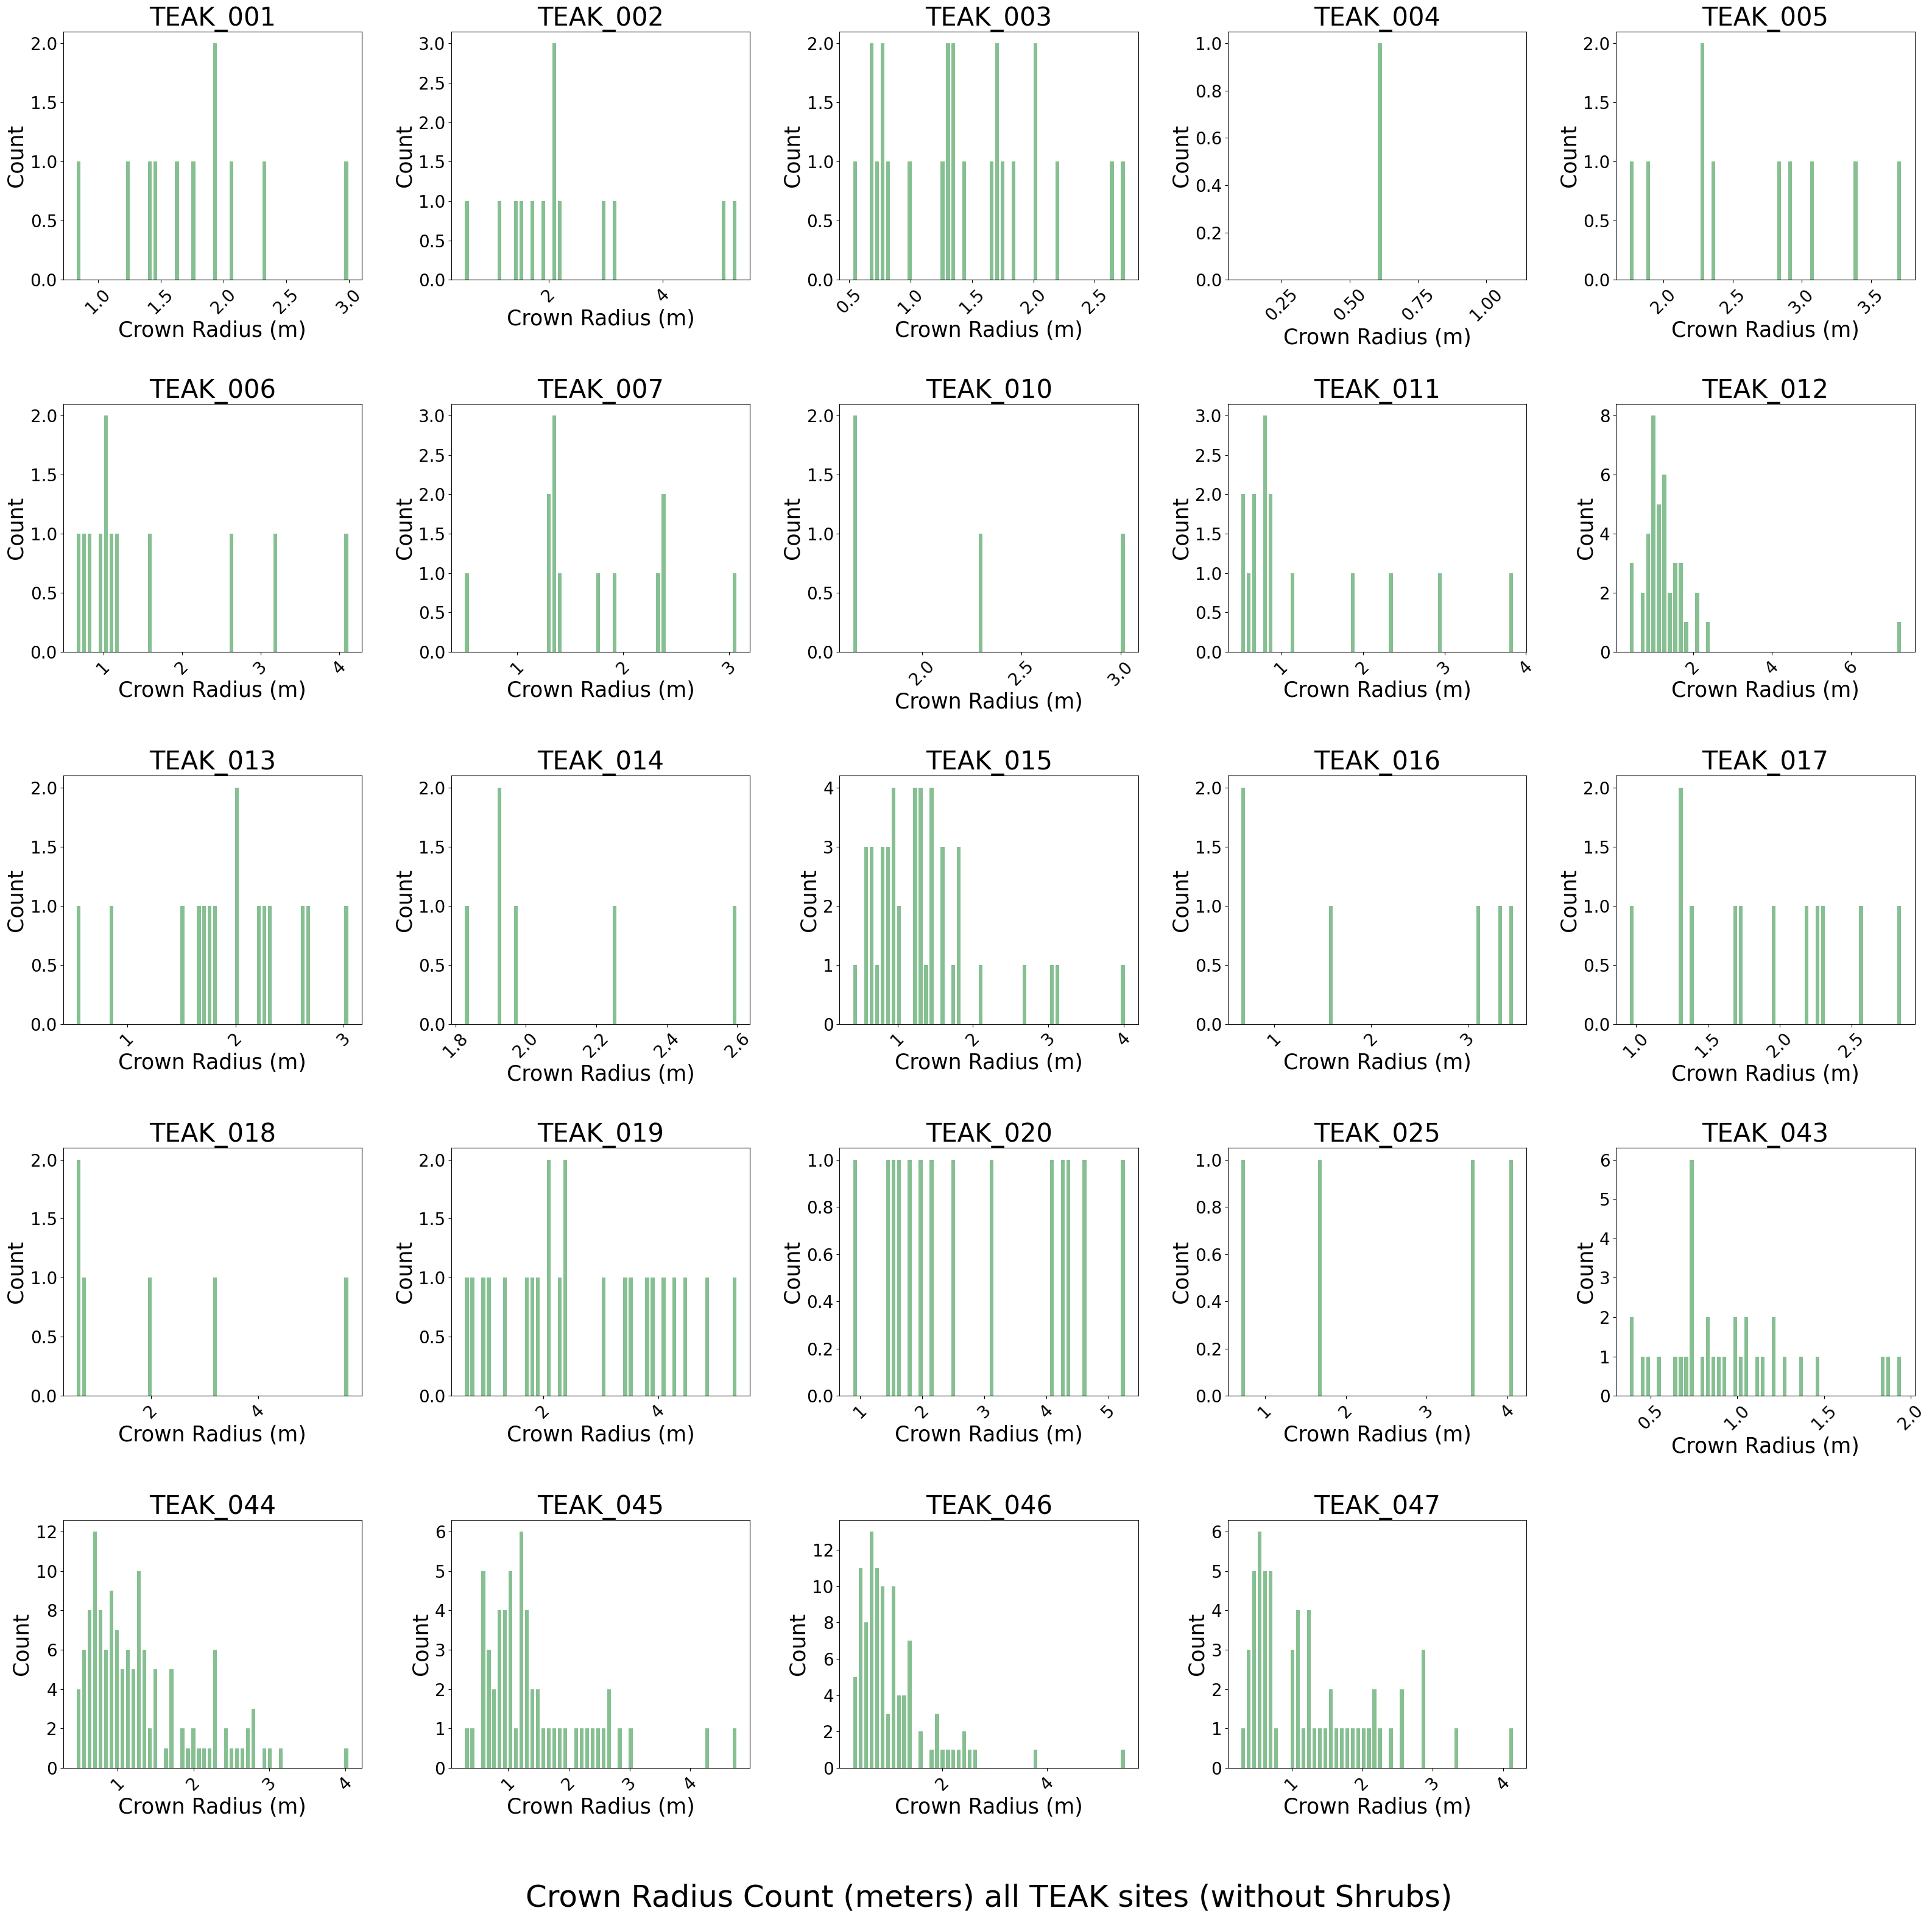

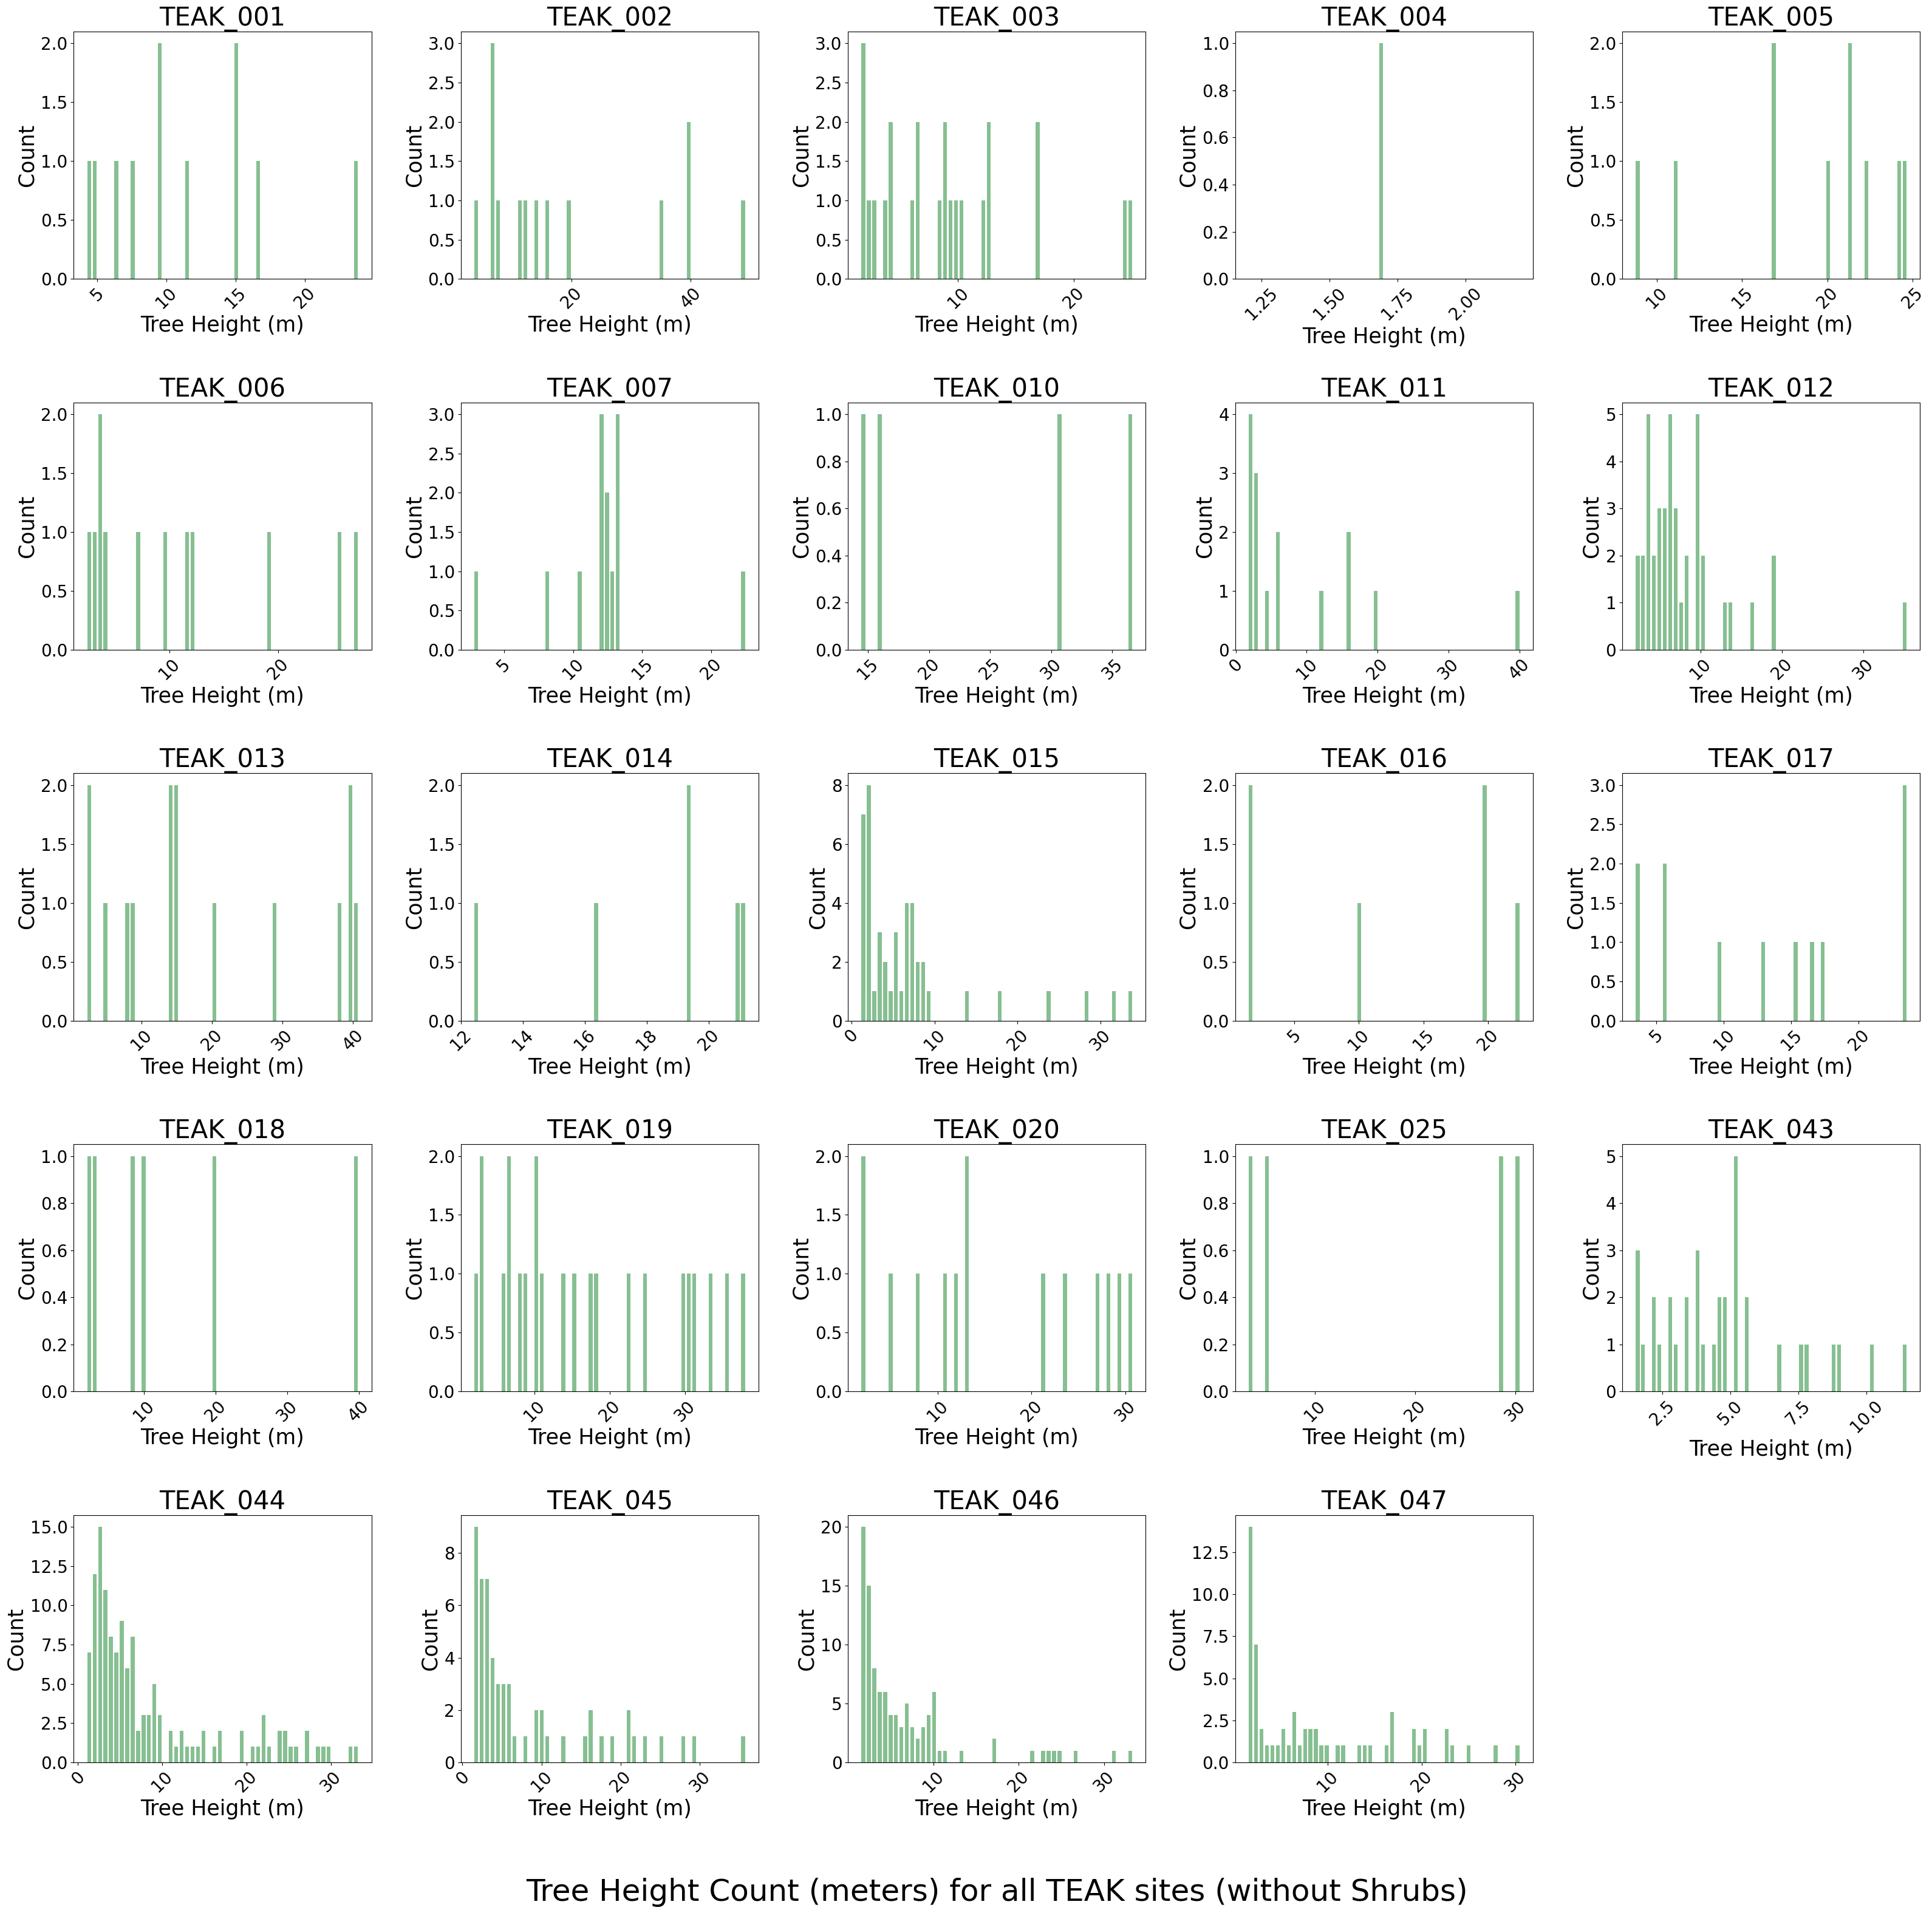

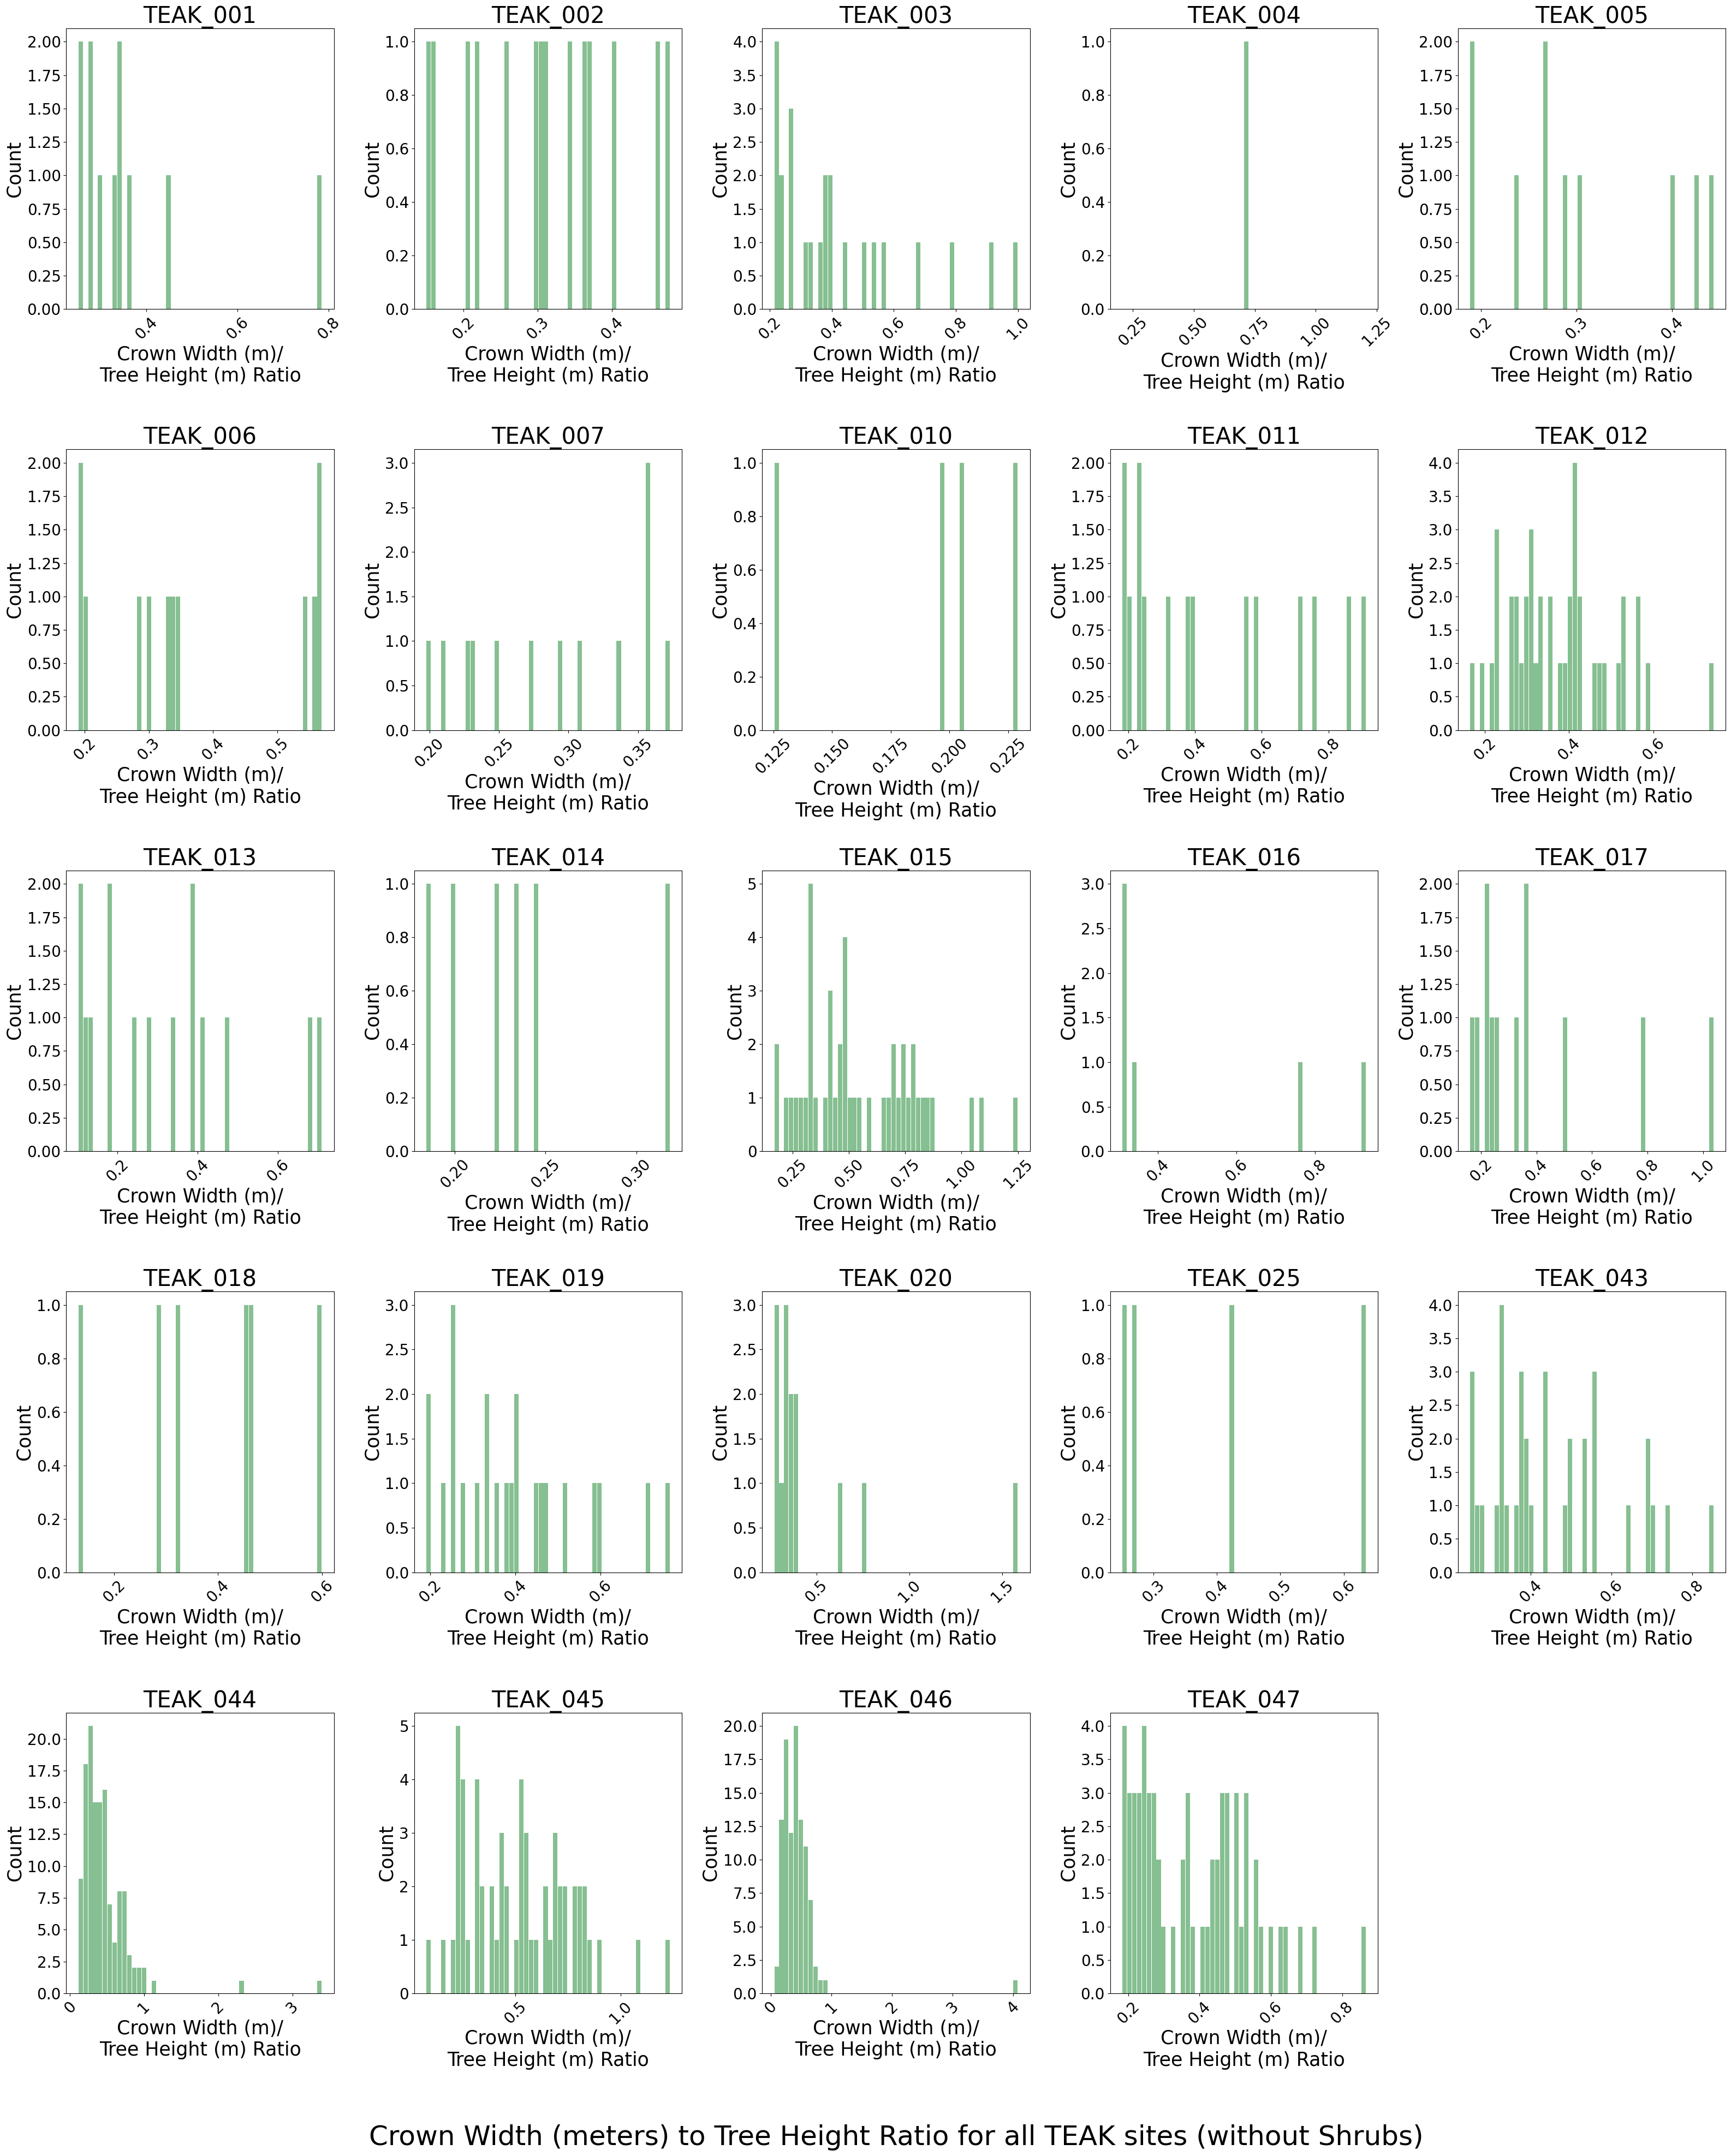

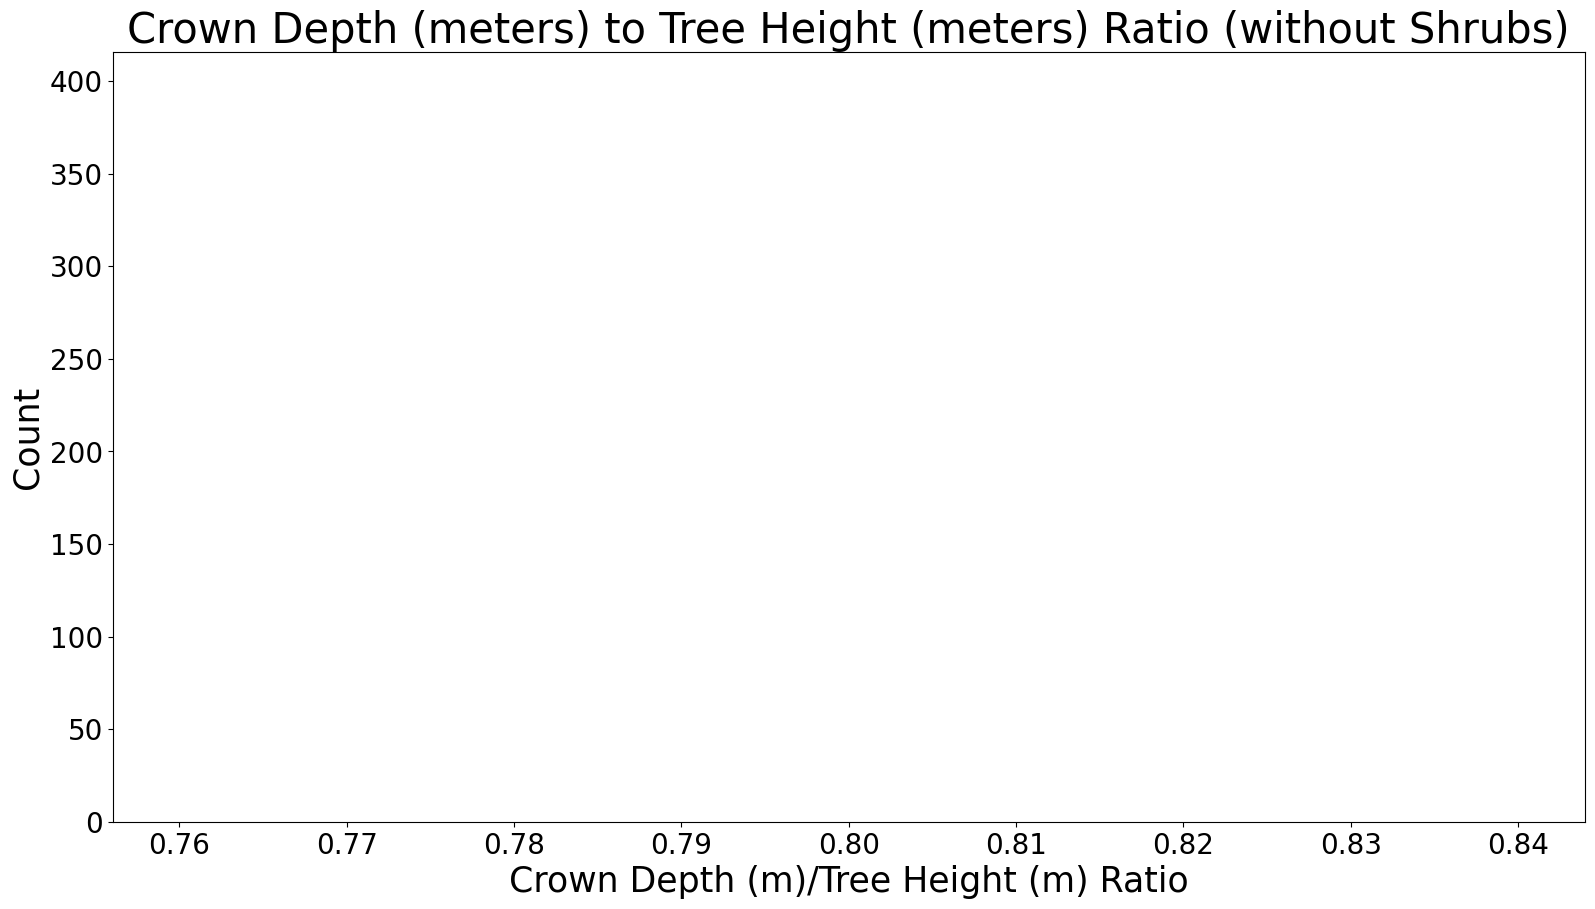

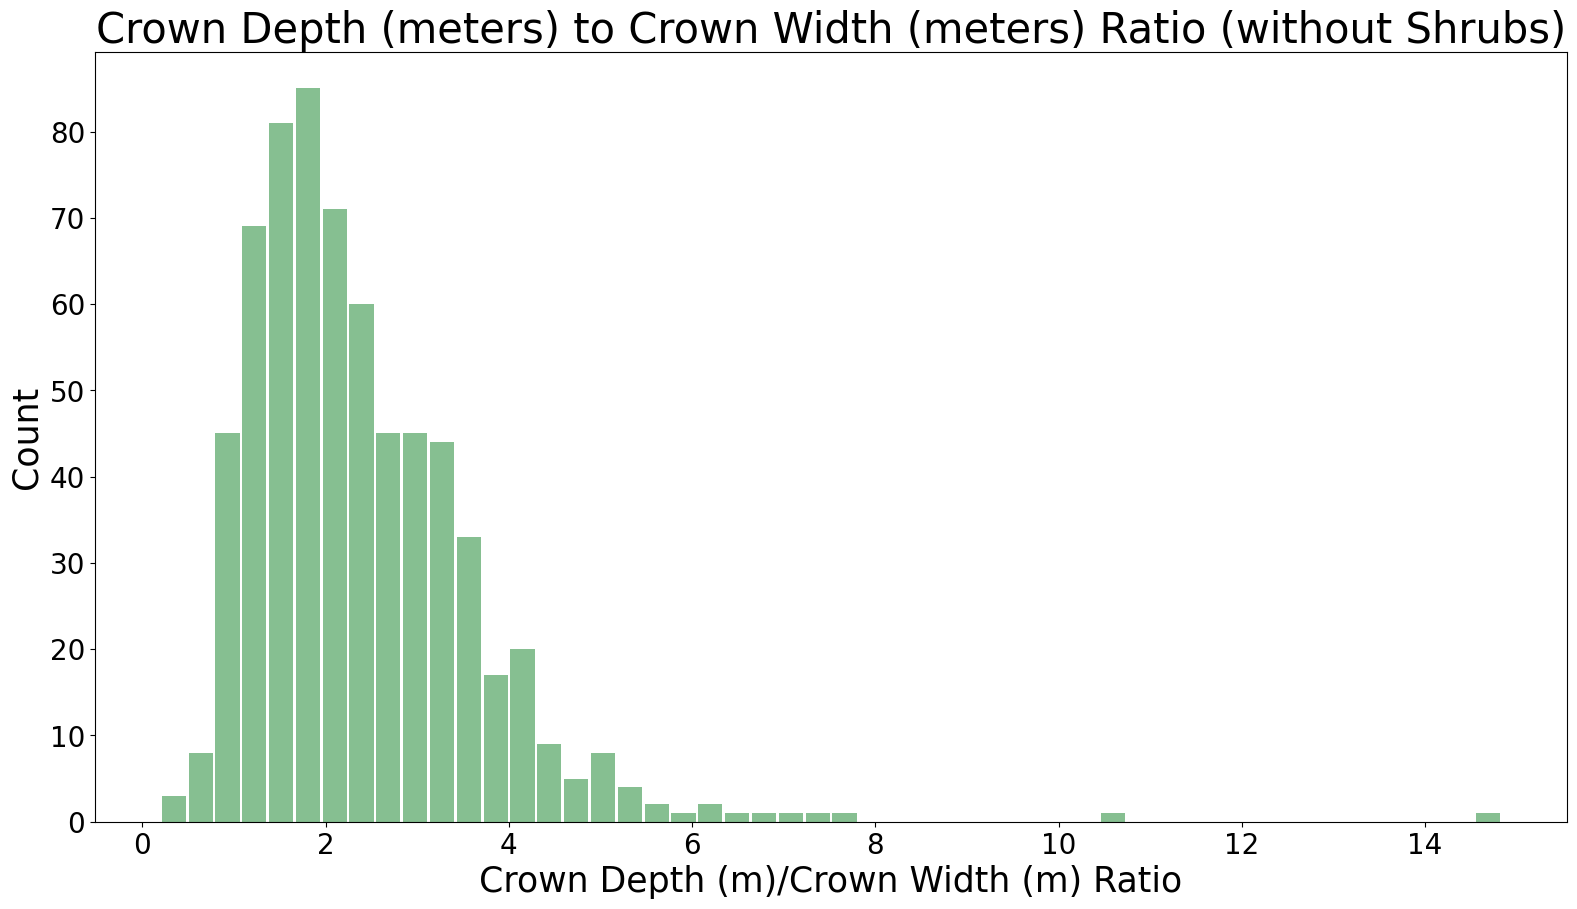

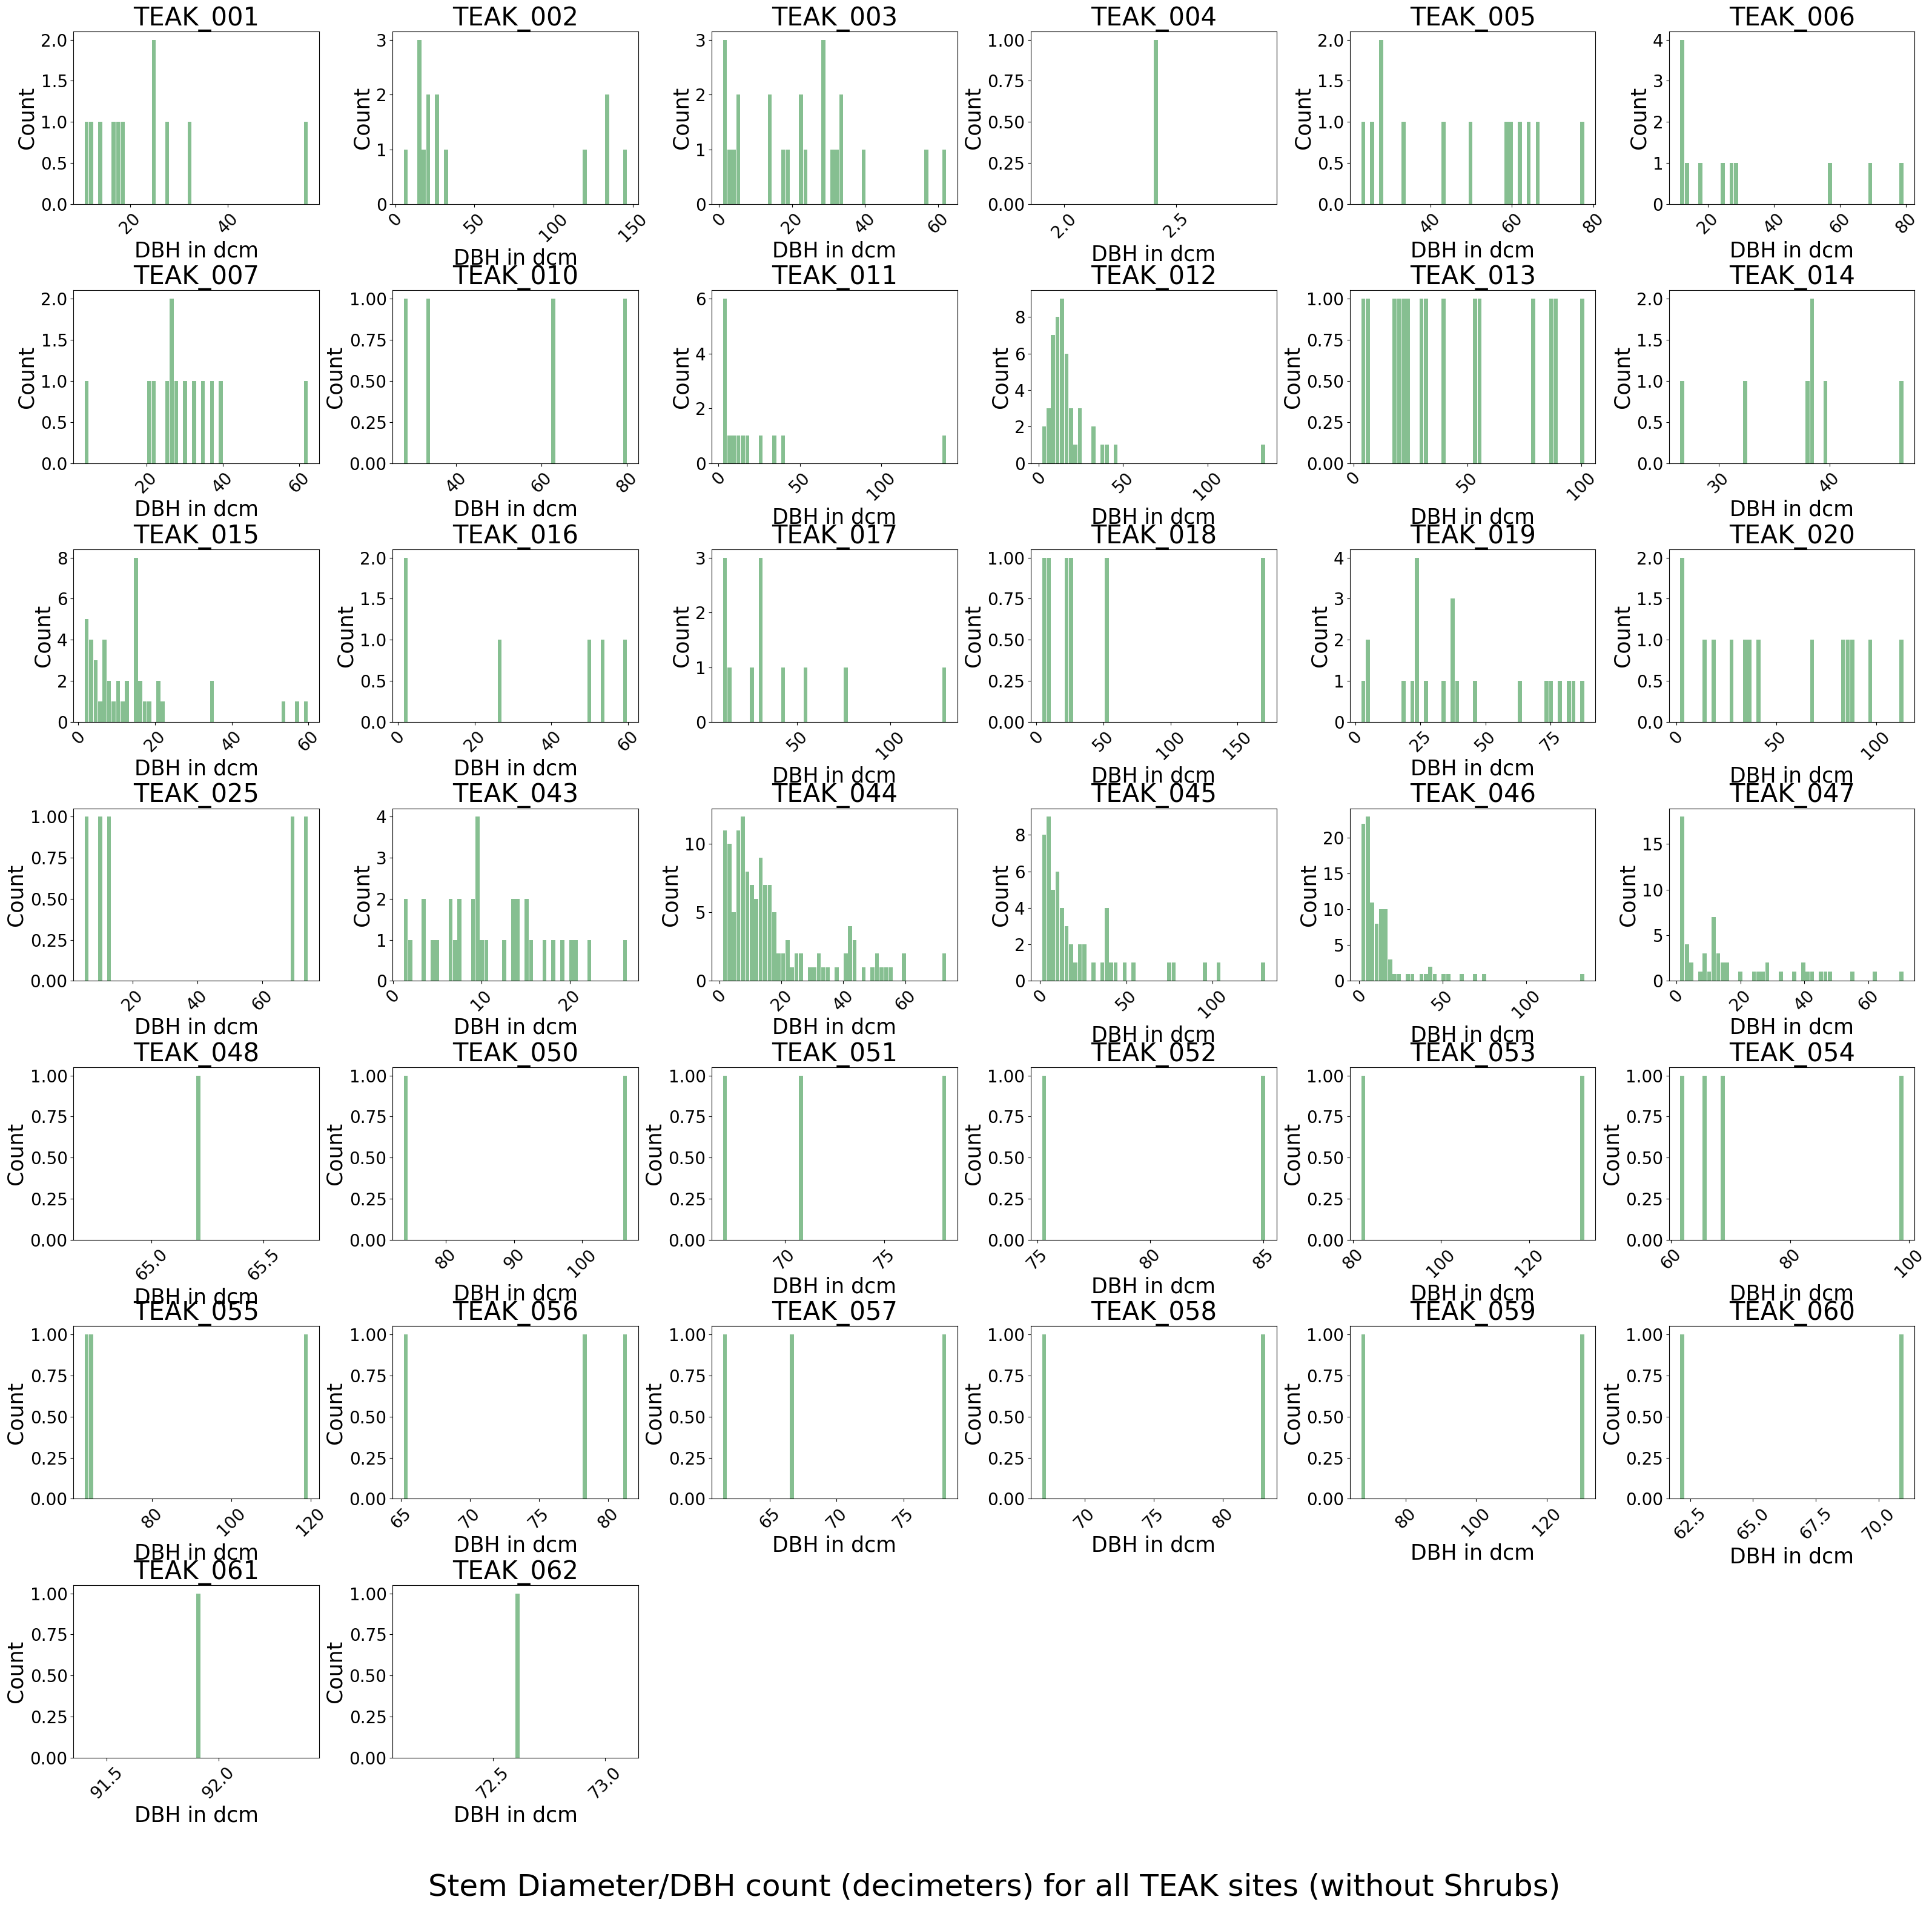

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# begin plots with shrub and save to file

# ax = filtered_df.hist(column = 'crown_radius', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)
ax = noshrub_height_nona_df.hist(column = 'crown_radius', by = noshrub_height_nona_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('Crown Radius (m)', fontsize=25)

plt.suptitle('Crown Radius Count (meters) all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_crown_radius.png')

# plt.suptitle('Crown Radius Count (meters) for TEAK_043 ', x=0.5, y=0.1, fontsize = 36)
# fig = ax.get_figure()
# fig.savefig(with_shrub_path + 'TEAK_crown_radius.png')

ax = noshrub_height_nona_df.hist(column = 'height', by = noshrub_height_nona_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('Tree Height (m)', fontsize=25)

plt.suptitle('Tree Height Count (meters) for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_height.png')

ax = noshrub_height_nona_df.hist(column = 'crown_width/h', by = noshrub_height_nona_df ['plotID'], bins=50, grid=False, figsize=(38,48), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('Crown Width (m)/\nTree Height (m) Ratio', fontsize=25)

plt.suptitle('Crown Width (meters) to Tree Height Ratio for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_crown_width_height_ratio.png')

ax = noshrub_height_nona_df.hist(column = 'crown_depth/h', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

ax[0][0].set_ylabel('Count', fontsize=25)
ax[0][0].set_xlabel('Crown Depth (m)/Tree Height (m) Ratio', fontsize=25)

plt.title('Crown Depth (meters) to Tree Height (meters) Ratio (without Shrubs)')
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_crown_depth_height_ratio.png')

ax = noshrub_height_nona_df.hist(column = 'crown_depth/crown_width', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

ax[0][0].set_ylabel('Count', fontsize=25)
ax[0][0].set_xlabel('Crown Depth (m)/Crown Width (m) Ratio', fontsize=25)

plt.title('Crown Depth (meters) to Crown Width (meters) Ratio (without Shrubs)')
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_crown_depth_crown_width_ratio.png')

ax = noshrub_stem_nona_df.hist(column = 'stemDiameter', by = noshrub_stem_nona_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count', fontsize=25)
        ax_x.set_xlabel('DBH in dcm', fontsize=25)

plt.suptitle('Stem Diameter/DBH count (decimeters) for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_DBH.png')

In [28]:
# test_df = app_indv['height'].dropna()
# test_df.sort_values(ascending = True, inplace = True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(test_df)

print(len(app_indv.index))

test_df = app_indv[(app_indv['growthForm'].str.contains('sapling') == False) | (pd.isna(app_indv['growthForm']))]

print(len(test_df.index))

test_df = test_df[(test_df['stemDiameter'] > 0.1) | ((pd.isna(test_df['growthForm'])))]

print(len(test_df.index))

test_df = test_df[test_df['plantStatus'].str.contains('Live')]

print(len(test_df.index))

test_df = test_df[test_df['date'].str.contains('2015') == False]

print(len(test_df.index))


5062
4031
3148
2369
1042


38
range(0, 38)


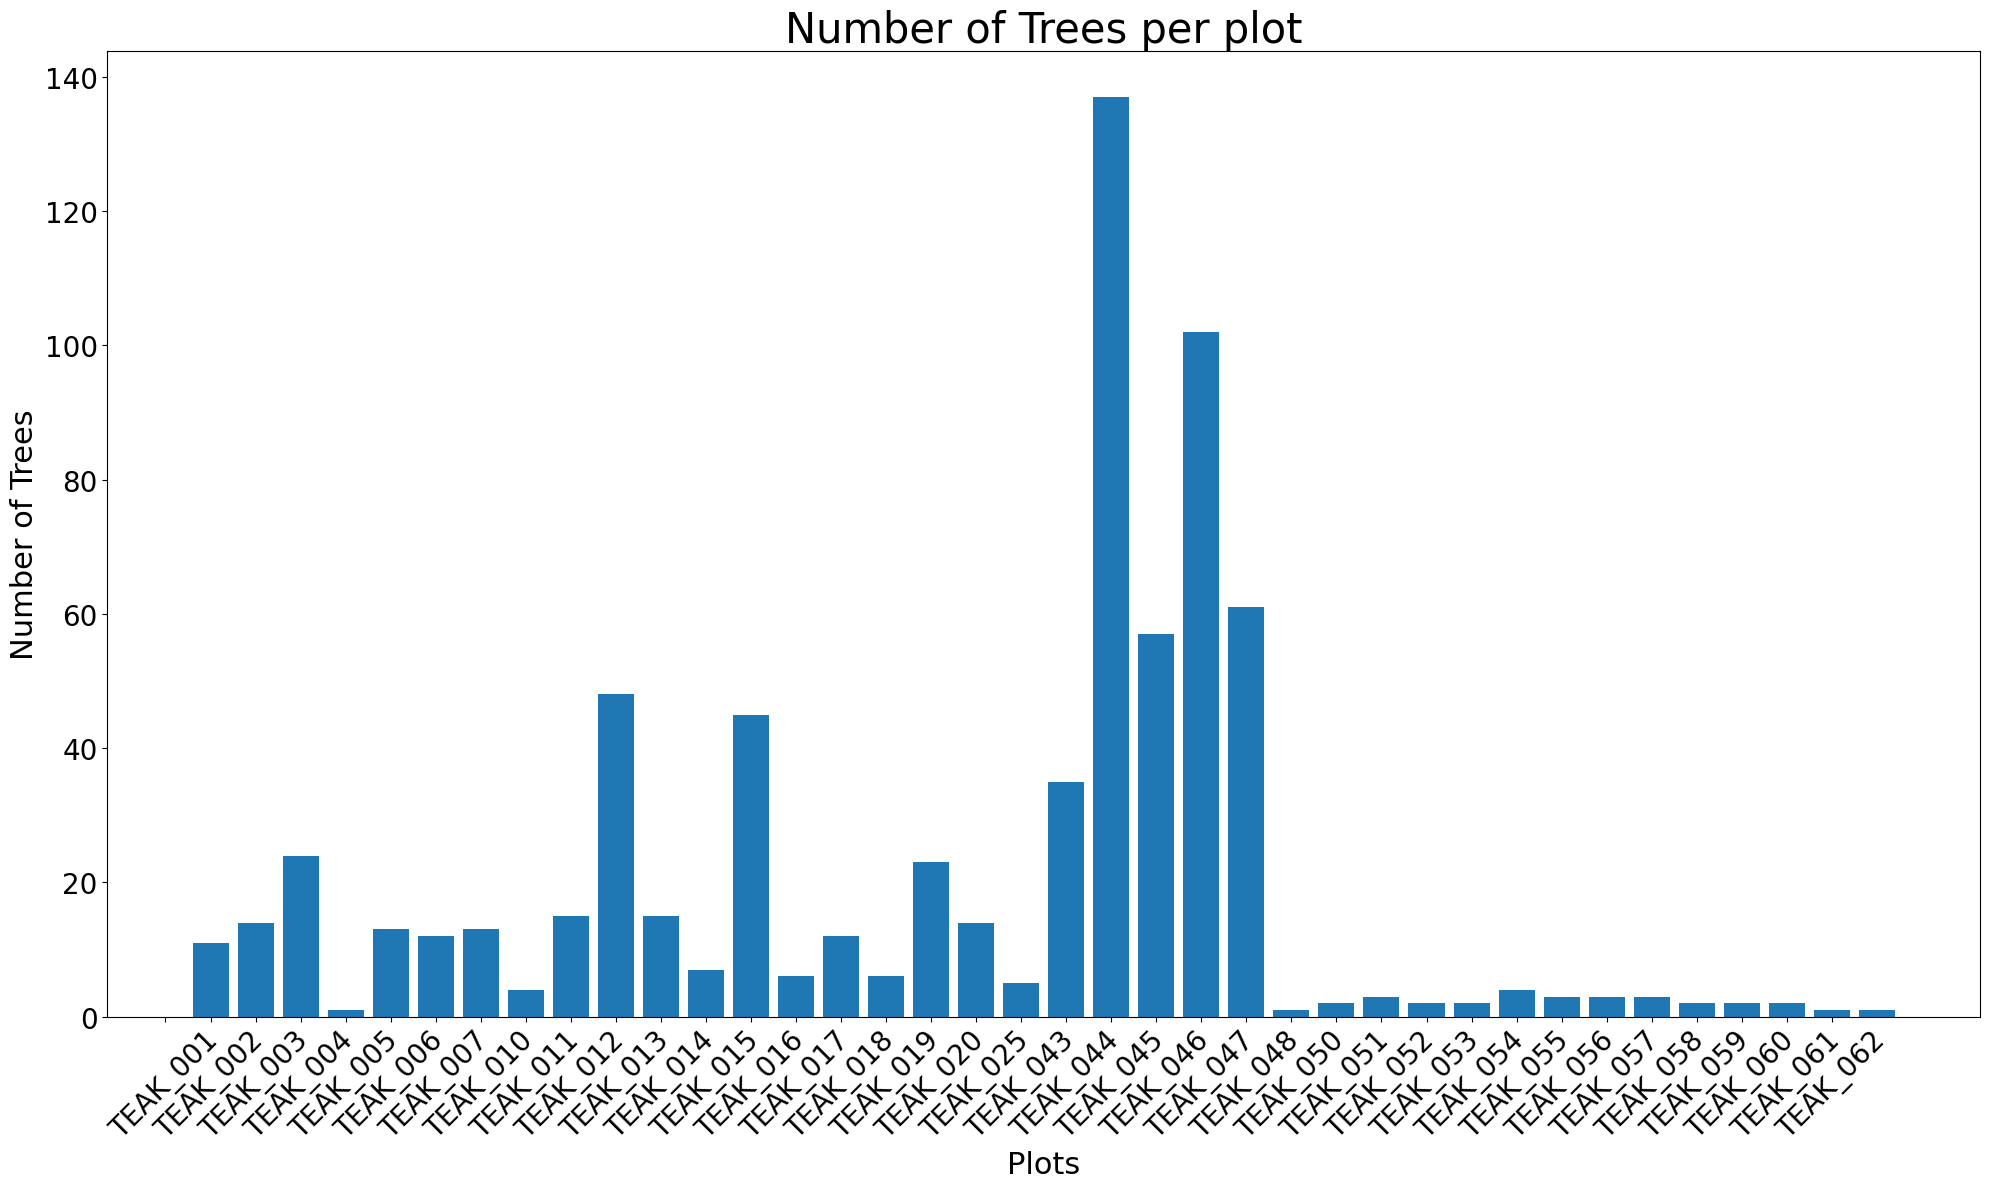

In [29]:
import matplotlib.pyplot as plt

noshrub_df = noshrub_df.sort_values(by=['plotID'])

print (noshrub_df['plotID'].nunique())

unique_counts = noshrub_df['plotID'].value_counts().sort_index()
bar_positions = range(len(unique_counts))
print (bar_positions)

plt.figure(figsize=(20, 12))
plt.bar(unique_counts.index, unique_counts.values)

plt.xlabel('Plots')
plt.ylabel('Number of Trees')
plt.title('Number of Trees per plot')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.xticks([pos - 1 for pos in bar_positions], unique_counts.index, rotation=45, ha = 'center')

plt.tight_layout()
plt.show()

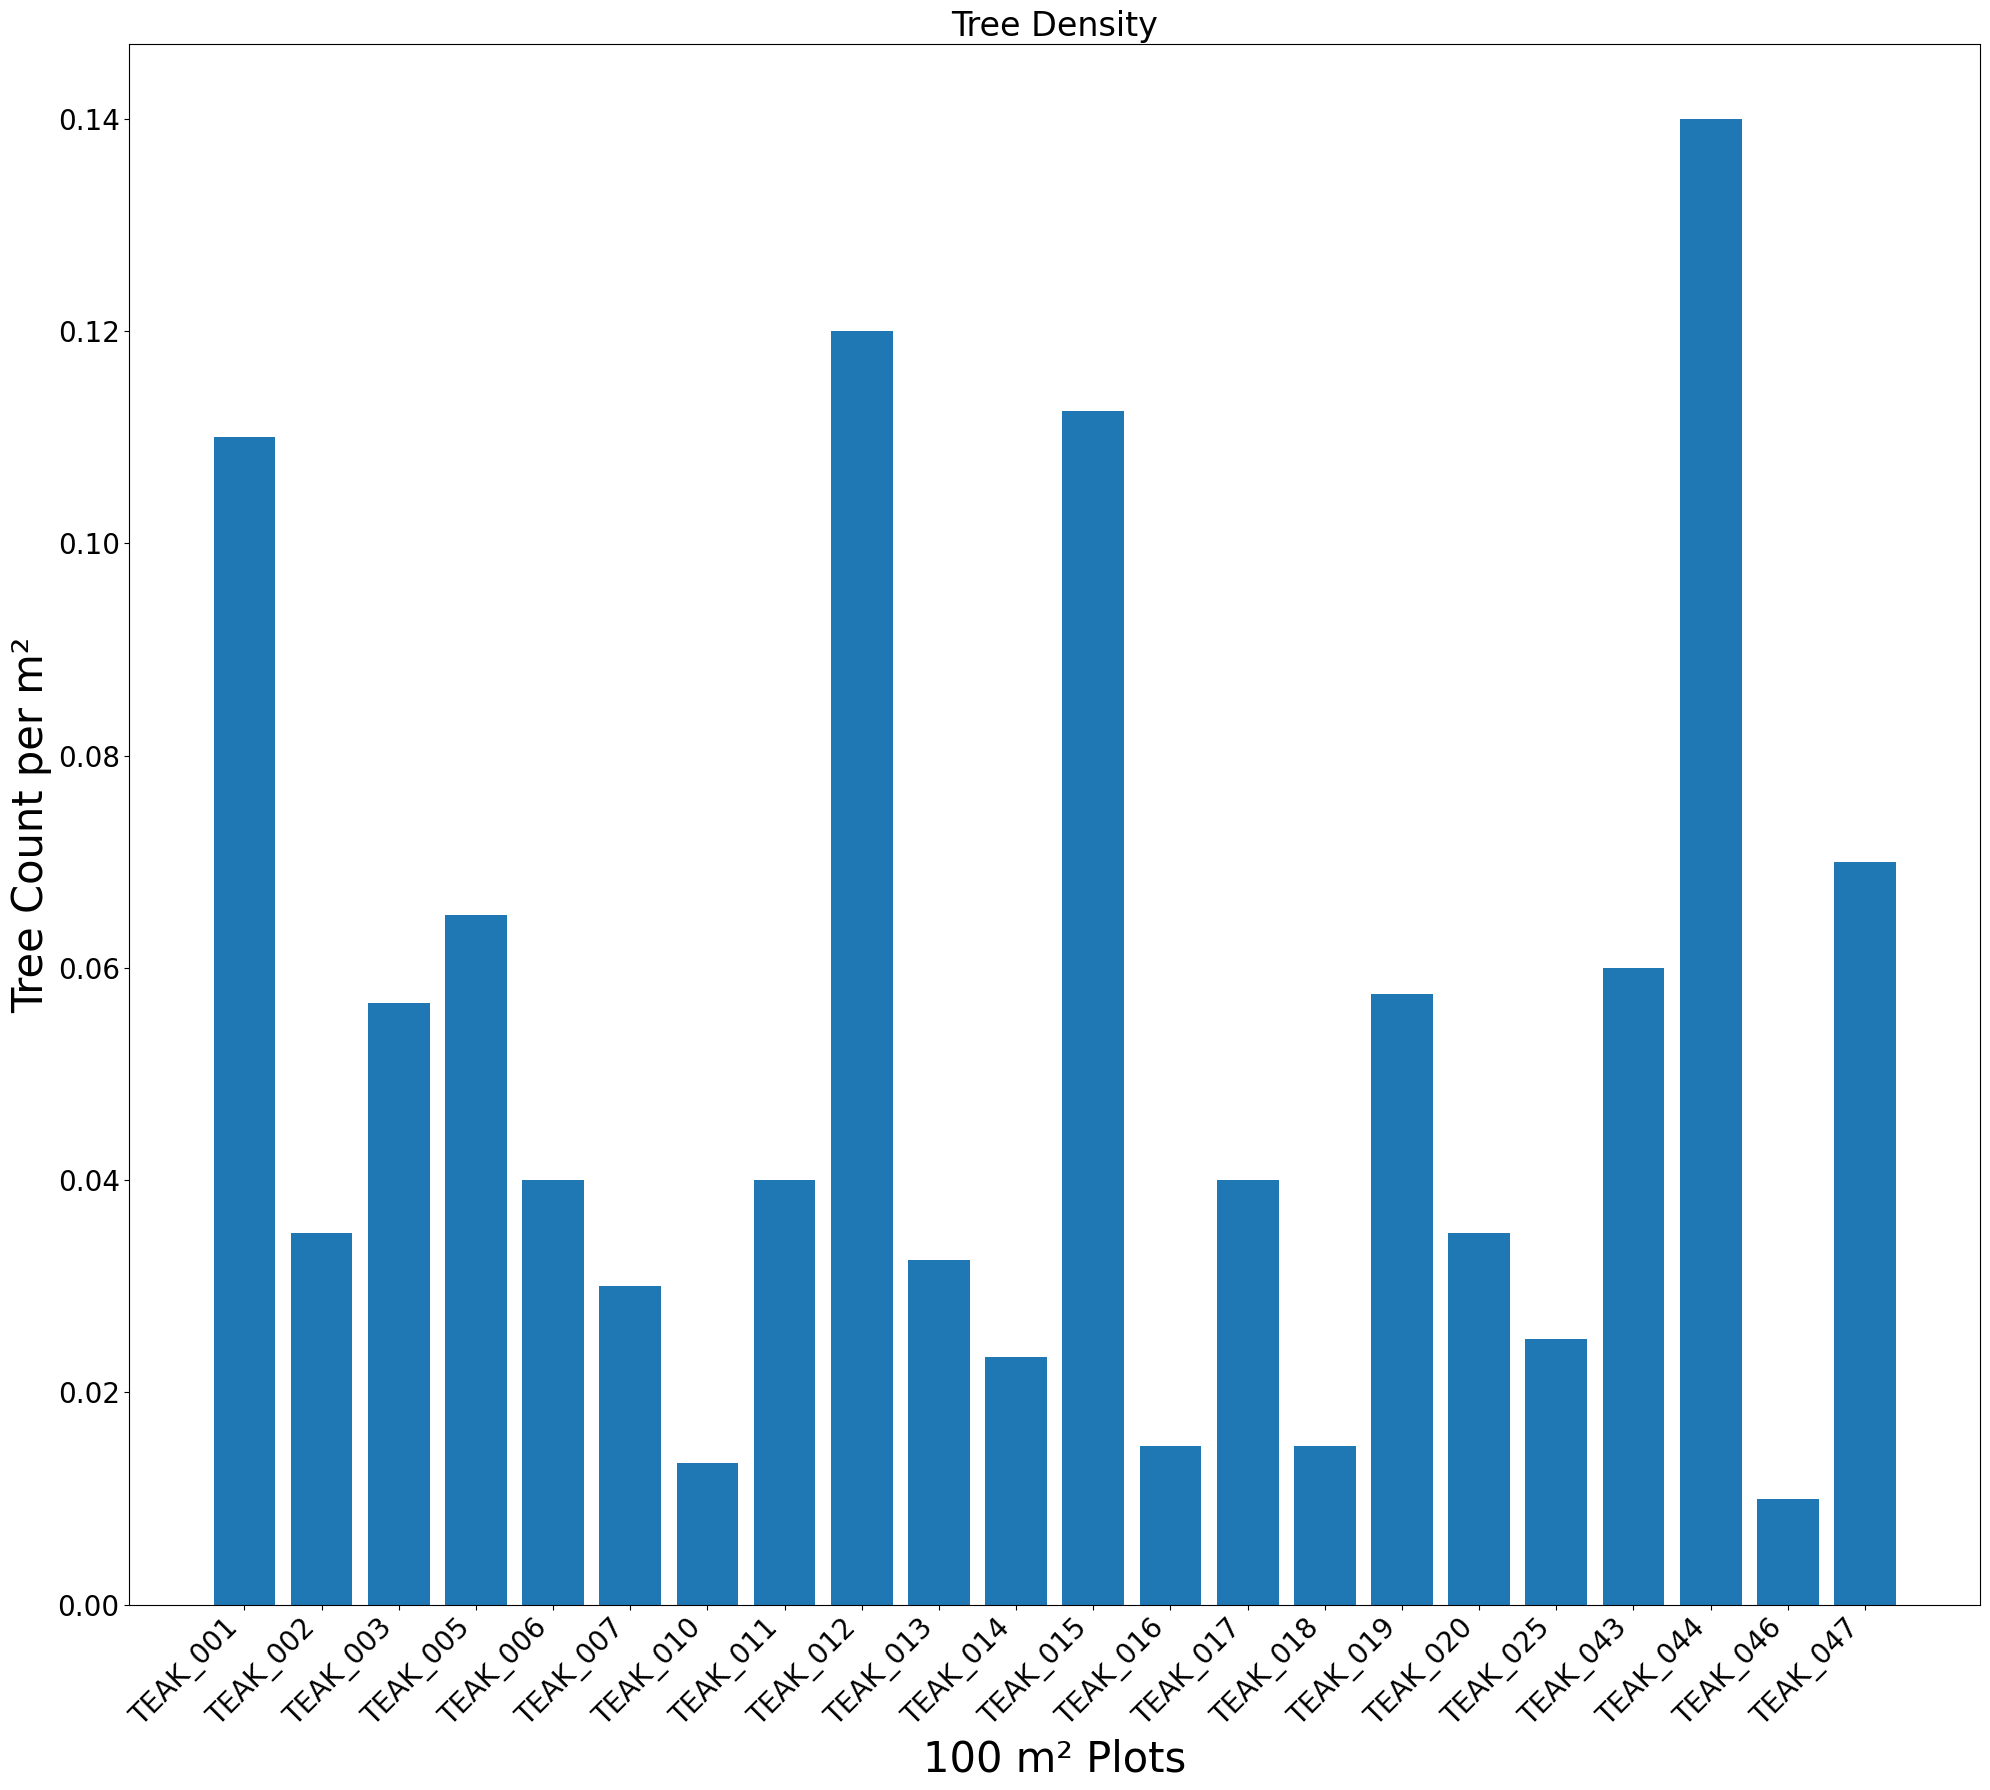

In [30]:
import matplotlib.pyplot as plt

root_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/'

noshrub_100_df = noshrub_100_df.sort_values(by=['plotID'])

# test_df = noshrub_stemheight_nona_100_df[noshrub_stemheight_nona_100_df['plotID'].str.contains('_044')]

# print (len(test_df))

filtered_df = app_indv[(app_indv['growthForm'].str.contains('sapling') == False) | (pd.isna(app_indv['growthForm']))]

drop_unknown_df = noshrub_100_df[noshrub_100_df['subplotID'].str.contains('unknown') == False]

# Calculate unique plotID values
unique_plotIDs = drop_unknown_df['plotID'].unique()

# Initialize a dictionary to store the normalized counts for each plotID
normalized_counts = {}

# Iterate over unique plotID values
for plot_id in unique_plotIDs:
    # Get corresponding group DataFrame
    with_unknowns_df = noshrub_100_df[noshrub_100_df['plotID'] == plot_id]
    without_unknowns_df = drop_unknown_df[drop_unknown_df['plotID'] == plot_id]

    # Calculate count of unique values in 'subplotID'
    subplot_unique_count = len(without_unknowns_df['subplotID'].unique())

    # Calculate count divided by (number of uniques in subplotID * 100)
    normalized_count = len(with_unknowns_df['subplotID']) / (subplot_unique_count * 100)

    # Store normalized count for the plotID
    normalized_counts[plot_id] = normalized_count

plt.figure(figsize=(20, 18))
# Create bar plot
plt.bar(range(len(normalized_counts)), normalized_counts.values())

plt.xlabel('100 m\u00B2 Plots')
plt.ylabel('Tree Count per m\u00B2')
plt.title('Tree Density')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.xticks(range(len(normalized_counts)), normalized_counts.keys(), rotation=45, ha='right')


# Save the figure to a file
plt.savefig(root_path + 'TEAK_tree_density_100.png')

# Displaying the plot
plt.tight_layout()
plt.show()

# plot_list = ['TEAK_043', 'TEAK_044', 'TEAK_046', 'TEAK_047']

# noshrub_100_filtered_df = noshrub_100_df[noshrub_100_df['plotID'].isin(plot_list)]
# pd.set_option('display.expand_frame_repr', False)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(noshrub_100_filtered_df[['individualID','plotID', 'date', 'subplotID', 'growthForm']])

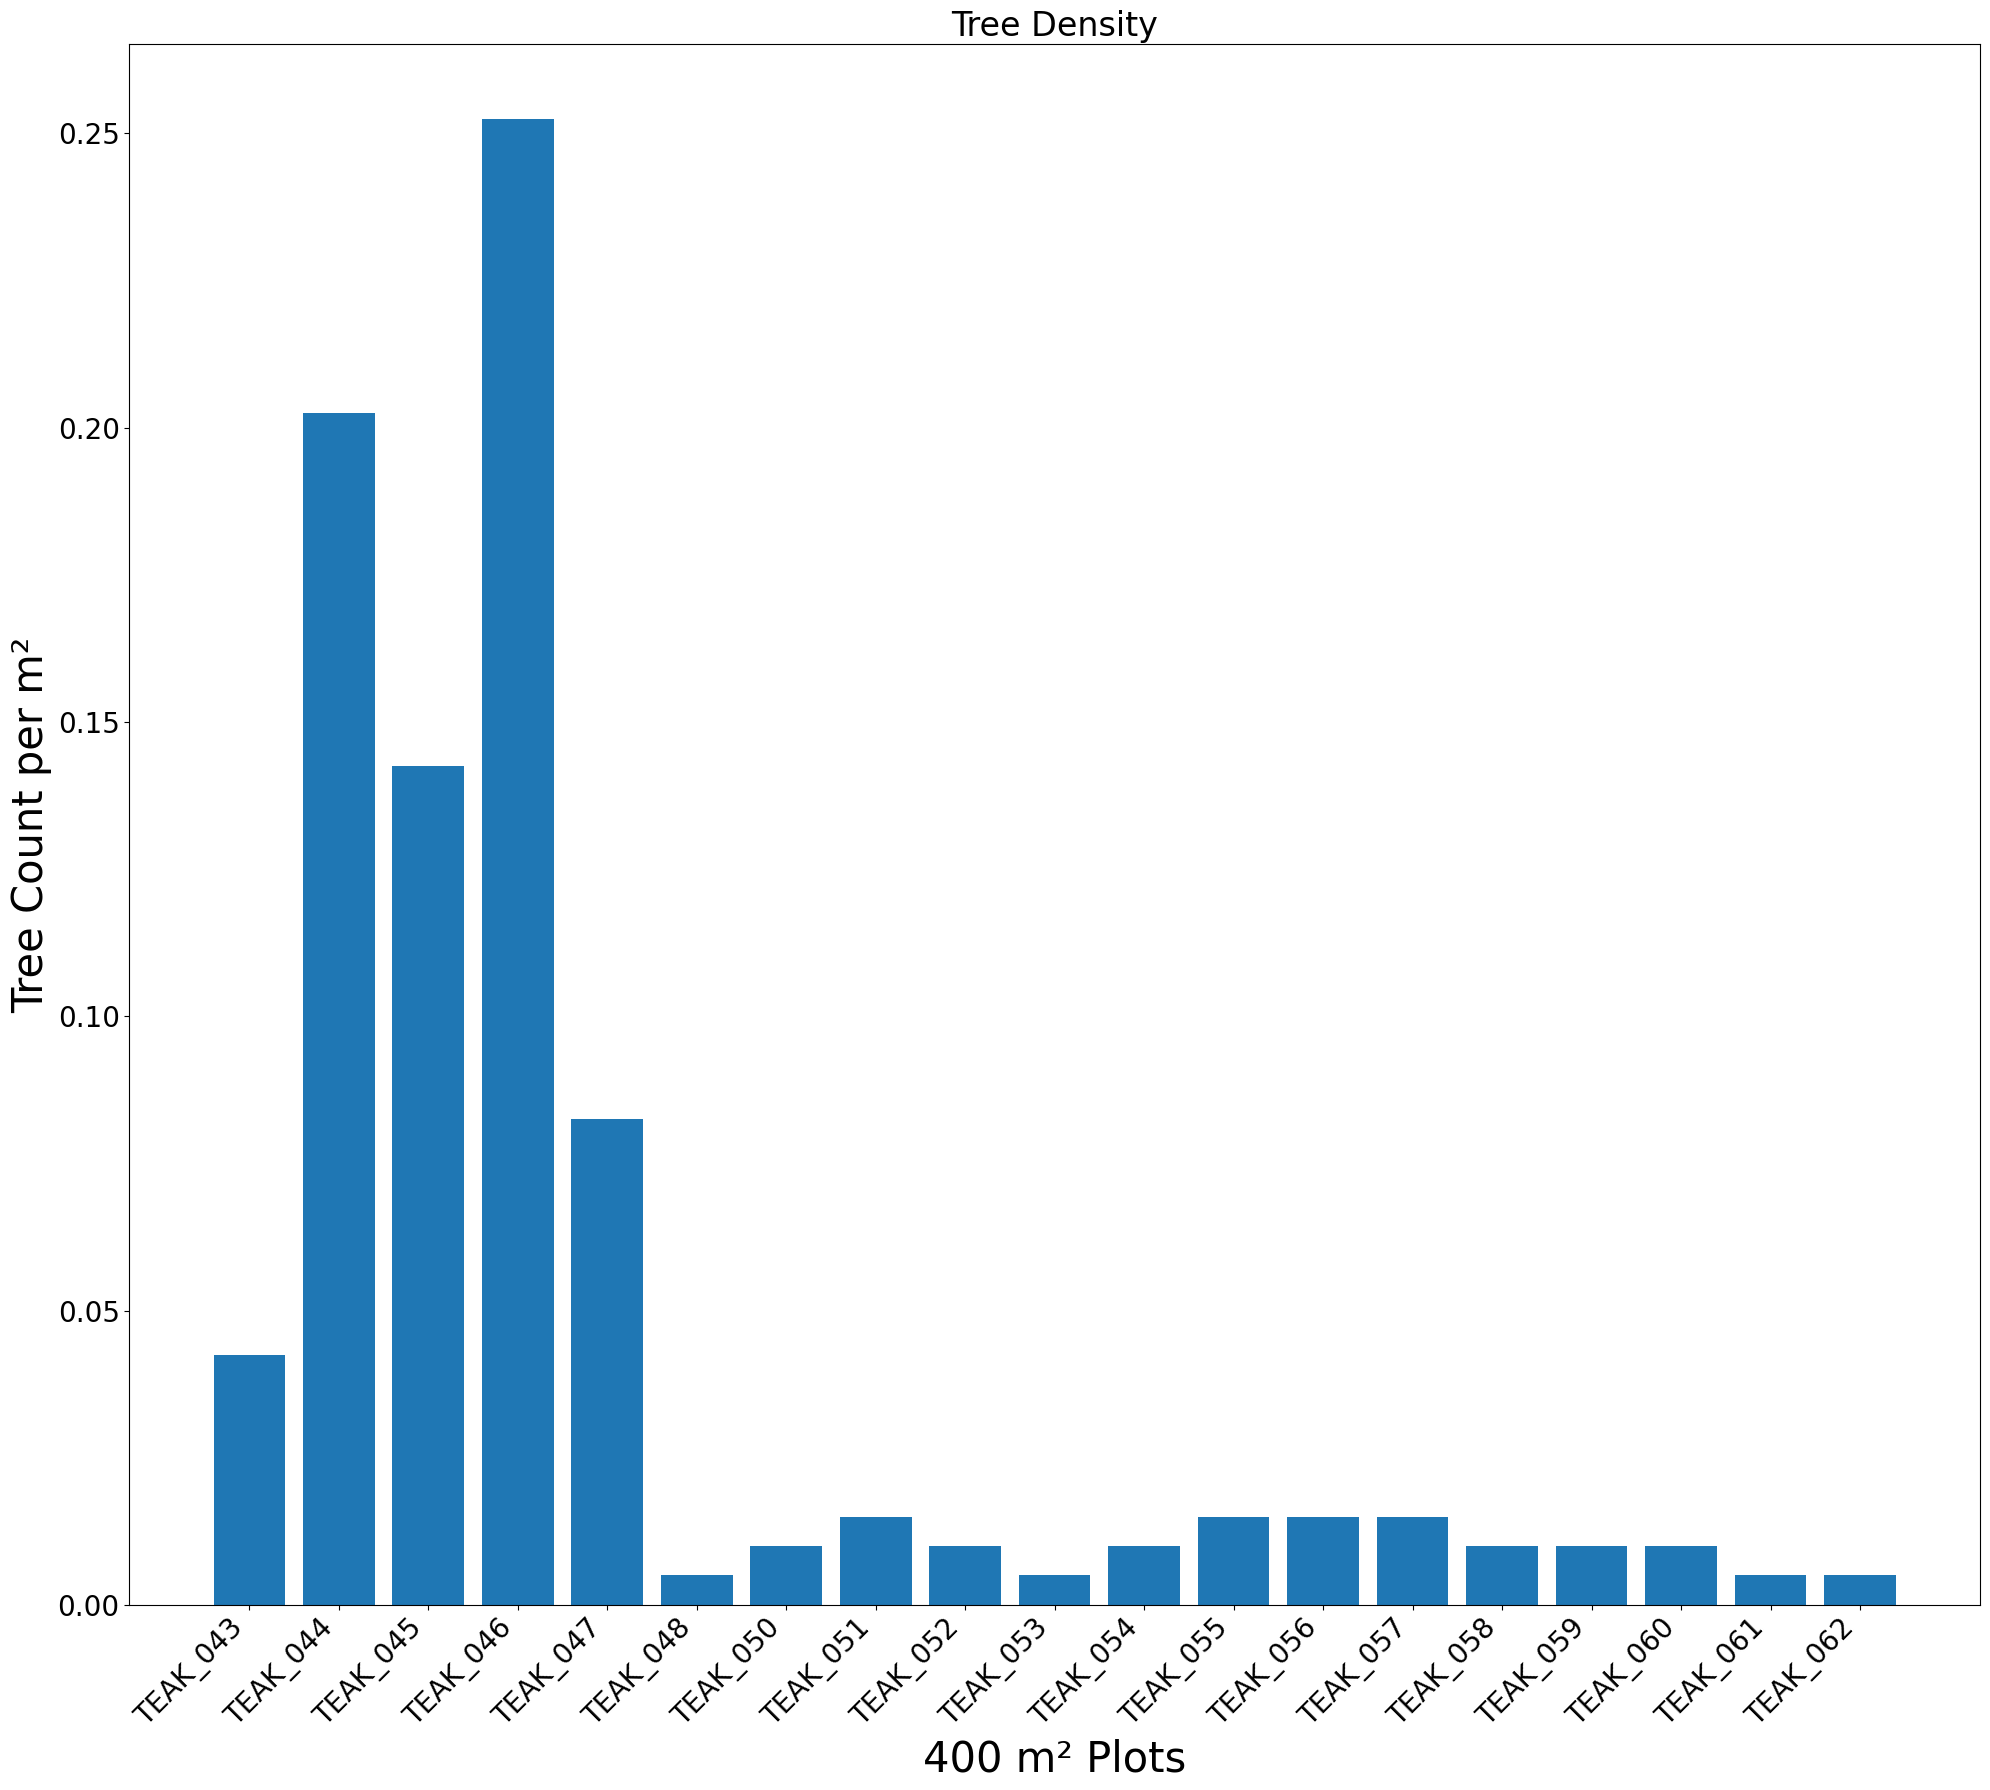

In [31]:

import matplotlib.pyplot as plt

root_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/'

noshrub_400_df = noshrub_400_df.sort_values(by=['plotID'])

drop_unknown_df = noshrub_400_df[noshrub_400_df['subplotID'].str.contains('unknown') == False]

# Calculate unique plotID values
unique_plotIDs = drop_unknown_df['plotID'].unique()

# Initialize a dictionary to store the normalized counts for each plotID
normalized_counts = {}

# Iterate over unique plotID values
for plot_id in unique_plotIDs:
    # Get corresponding group DataFrame
    with_unknowns_df = noshrub_400_df[noshrub_400_df['plotID'] == plot_id]
    without_unknowns_df = drop_unknown_df[drop_unknown_df['plotID'] == plot_id]

    # Calculate count of unique values in 'subplotID'
    subplot_unique_count = len(without_unknowns_df['subplotID'].unique())

    # Calculate count divided by (number of uniques in subplotID * 100)
    normalized_count = len(with_unknowns_df['subplotID']) / (subplot_unique_count * 200)

    # Store normalized count for the plotID
    normalized_counts[plot_id] = normalized_count

plt.figure(figsize=(20, 18))
plt.bar(range(len(normalized_counts)), normalized_counts.values())

plt.xlabel('400 m\u00B2 Plots')
plt.ylabel('Tree Count per m\u00B2')
plt.title('Tree Density')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
# plt.xticks([pos - 0.5 for pos in bar_positions], unique_counts.index, rotation=45)
plt.xticks(range(len(normalized_counts)), normalized_counts.keys(), rotation=45, ha='right')
plt.tight_layout()

# Save the figure to a file
plt.savefig(root_path + 'TEAK_tree_density_400.png')

# Displaying the plot
plt.show()

In [37]:
import folium
from pyproj import Proj, transform

map_tag_df = pd.read_csv("C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_maptag_allyears_2022.csv")
subplot_loc_df = pd.read_csv('C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_subplotloc_allyears_2022.csv')

# print (noshrub_100_df)
# print (map_tag_df)

# Mapping and tagging csv contains pointID, stemDistance and stemAzimuth, adds these values to the merged dataframes
# Note:  when merging dataframes with the same column names, pd.merge(x, y), duplicate column names will be appended with _x and _y suffixes
merged_100_df = pd.merge(noshrub_100_df, map_tag_df, on='individualID', how='left')
merged_400_df = pd.merge(noshrub_400_df, map_tag_df, on='individualID', how='left')
merged_100_df = merged_100_df.dropna(subset=['stemDistance', 'stemAzimuth'])
merged_400_df = merged_400_df.dropna(subset=['stemDistance', 'stemAzimuth'])
merged_100_df = merged_100_df.rename(columns = {'namedLocation_x': 'namedLocation'})
merged_400_df = merged_400_df.rename(columns = {'namedLocation_x': 'namedLocation'})

merged_100_df['pointID'] = merged_100_df['pointID'].astype(int)
merged_100_df['pointID'] = merged_100_df['pointID'].astype(str)
merged_400_df['pointID'] = merged_400_df['pointID'].astype(int)
merged_400_df['pointID'] = merged_400_df['pointID'].astype(str)

# drops rows where subplotID may be:  unknown_100, unknown_400
merged_100_without_unknown_df = merged_100_df[merged_100_df['subplotID'].str.contains('unknown') == False]
merged_400_without_unknown_df = merged_400_df[merged_400_df['subplotID'].str.contains('unknown') == False]

# Define the UTM zone and hemisphere (e.g., UTM zone 11N for San Francisco)
utm_zone = 11
southern_hemisphere = False  # Set to True if in the southern hemisphere

# Create a UTM projection object
utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84', south=southern_hemisphere)

# This initializes the values to be calculated
merged_100_df[['plotptid','stemAzimuthRad', 'easting', 'northing', 'latitude', 'longitude']] = np.NaN

for index, row in merged_100_df.iterrows():
    # This constructs the plotptid which is combination of namedLocation from original appindv csv, which may look like:  TEAK_045.basePlot.vst
    # with mapping and tagging csv, on unique individualID.  mapping and tagging contains pointID, so plotptid may look like:  TEAK_018.basePlot.vst.51
    plotptid = row ['namedLocation'] + "." + row ['pointID']
    merged_100_df.at[index, 'plotptid'] = plotptid

    # if plotptid is found in subplotloc csv, grab the easting and northing coordinates of the plot center, and calculate each tree's easting and northing
    # based on stemDistance and stemAzimuth from the plot center point
    found = (subplot_loc_df['locationName'] == plotptid).any()
    if (found):
        location_by_individual = subplot_loc_df[subplot_loc_df['locationName'] == plotptid]

        stemAzimuthRad = (row['stemAzimuth'] * np.pi)/180
        easting = float(location_by_individual['easting'].values) + float(row['stemDistance']) * np.sin(stemAzimuthRad)
        northing = float(location_by_individual['northing'].values) + float(row['stemDistance'] * np.cos(stemAzimuthRad))
        longitude, latitude = utm_proj(easting, northing, inverse=True)
        # print(easting, northing, latitude, longitude)

        merged_100_df.at[index, 'stemAzimuthRad'] = stemAzimuthRad
        merged_100_df.at[index, 'easting'] = easting
        merged_100_df.at[index, 'northing'] = northing
        merged_100_df.at[index, 'latitude'] = latitude
        merged_100_df.at[index, 'longitude'] = longitude

        # # Drop unnecessary columns
        # merged_100_df.drop(columns=['stemDistance', 'stemAzimuthRad'], inplace=True)

merged_100_df['easting'] = merged_100_df['easting'].astype(float)
merged_100_df['northing'] = merged_100_df['northing'].astype(float)

merged_400_df[['plotptid','stemAzimuthRad', 'easting', 'northing', 'latitude', 'longitude']] = np.NaN

for index, row in merged_400_df.iterrows():
    plotptid = row ['namedLocation'] + "." + row ['pointID']
    merged_400_df.at[index, 'plotptid'] = plotptid

    found = (subplot_loc_df['locationName'] == plotptid).any()
    if (found):
        location_by_individual = subplot_loc_df[subplot_loc_df['locationName'] == plotptid]

        stemAzimuthRad = (row['stemAzimuth'] * np.pi)/180
        easting = float(location_by_individual['easting'].values) + float(row['stemDistance']) * np.sin(stemAzimuthRad)
        northing = float(location_by_individual['northing'].values) + float(row['stemDistance'] * np.cos(stemAzimuthRad))
        longitude, latitude = utm_proj(easting, northing, inverse=True)
        # print(easting, northing, latitude, longitude)

        merged_400_df.at[index, 'stemAzimuthRad'] = stemAzimuthRad
        merged_400_df.at[index, 'easting'] = easting
        merged_400_df.at[index, 'northing'] = northing
        merged_400_df.at[index, 'latitude'] = latitude
        merged_400_df.at[index, 'longitude'] = longitude

        # # Drop unnecessary columns
        # merged_100_df.drop(columns=['stemDistance', 'stemAzimuthRad'], inplace=True)

merged_400_df['easting'] = merged_400_df['easting'].astype(float)
merged_400_df['northing'] = merged_400_df['northing'].astype(float)

# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('display.float_format', '{:.6f}'.format)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(merged_100_df[['individualID', 'plotptid', 'pointID', 'subplotID', 'stemDistance', 'stemAzimuth', 'stemAzimuthRad', 'easting', 'northing', 'latitude', 'longitude']])
#     print(merged_100_df)


### This block creates a folium object and plots each tree's location on the map

m = folium.Map(location=[37.00583, -119.00602], zoom_start=12)

def popup_construct(each_point):
    lat = round(each_point['latitude'], 4)
    long = round(each_point['longitude'], 4)
    pop = (
        'plotID: ' + str(each_point['plotID_x']) + ',<br><br>subplotID: ' + str(each_point['subplotID']) + 
        ',<br><br>individualID: ' + str(each_point['individualID']) + 
        ',<br><br>lat: ' + str(lat) + ', ' + '<br><br>long: ' + str(long)
        )
    return pop

for index, row in merged_100_df.iterrows():
    # this formats the popup window with an iframe and sets its width to display
    iframe = folium.IFrame(popup_construct(row))
    popup = folium.Popup(iframe, min_width=300, max_width=300)

    if (pd.notna(row['easting'])):

        folium.Marker(
        location = [row['latitude'], row['longitude']],
        popup = popup,
        icon = folium.Icon(color = 'red')
        ).add_to(m)

        folium.Circle(
            location = [row['latitude'], row['longitude']],
            radius = 1,
            fill = True,
            color = 'red',
            # popup = popup,
        ).add_to(m)

for index, row in merged_400_df.iterrows():
    # this formats the popup window with an iframe and sets its width to display
    iframe = folium.IFrame(popup_construct(row))
    popup = folium.Popup(iframe, min_width=300, max_width=300)

    if (pd.notna(row['easting'])):

        folium.Marker(
        location = [row['latitude'], row['longitude']],
        popup = popup,
        icon = folium.Icon(color = 'blue')
        ).add_to(m)

        folium.Circle(
            location = [row['latitude'], row['longitude']],
            radius = 1,
            fill = True,
            color = 'blue',
            # popup = popup,
        ).add_to(m)

m.save(root_path + 'TEAK_100_vs_400_new.html')
m

C:\Users\allen\AppData\Local\Temp\ipykernel_9336\1602128199.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TEAK_001.basePlot.vst.41' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_100_df.at[index, 'plotptid'] = plotptid
C:\Users\allen\AppData\Local\Temp\ipykernel_9336\1602128199.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  easting = float(location_by_individual['easting'].values) + float(row['stemDistance']) * np.sin(stemAzimuthRad)
C:\Users\allen\AppData\Local\Temp\ipykernel_9336\1602128199.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before pe

In [36]:
# for index in unique_counts.index:
#     test_df = noshrub_height_nona_df[noshrub_height_nona_df['plotID'].str.contains(index)]
    # pd.set_option('display.expand_frame_repr', False)
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #     # print(test_df[['individualID','plotID', 'date', 'subplotID', 'growthForm', 'maxCrownDiameter', 'crown_depth', 'height']])
    #     print(noshrub_stemheight_nona_df)


# # Assuming df1 and df2 are your DataFrames and you want to find duplicates between columns 'column1' and 'column2'
# merged_df = pd.merge(noshrub_100_df, noshrub_400_df, on='individualID', how='inner')
# # Select rows where the values in column1 and column2 are the same
# duplicate_rows = merged_df[merged_df['individualID'] == merged_df['individualID']]
# print(merged_df)


# csv_filename = 'TEAK_entries_perplot_100.csv'
# noshrub_100_df.to_csv(root_path + csv_filename, index = False)

# csv_filename = 'TEAK_entries_perplot_400.csv'
# noshrub_400_df.to_csv(root_path + csv_filename, index = False)

csv_filename_100 = 'TEAK_entries_perplot_100.csv'
column_names_100 = merged_100_df.columns.tolist()
print(column_names_100)


csv_filename_400 = 'TEAK_entries_perplot_400.csv'
column_names_400 = merged_400_df.columns.tolist()
print(column_names_400)

columns_to_export = ['uid_x', 'namedLocation', 'date_x', 'plotID_x', 'subplotID', 'individualID', 'growthForm', 'plantStatus', 'stemDiameter', 'height', 'baseCrownHeight',
                     'maxCrownDiameter', 'ninetyCrownDiameter', 'crown_radius', 'crown_width', 'crown_depth', 'taxonID', 'scientificName', 'plotptid', 'stemAzimuthRad', 'easting', 'northing', 'latitude', 'longitude']

df_100_to_export = merged_100_df[columns_to_export]
df_400_to_export = merged_400_df[columns_to_export]

print(len(noshrub_height_nona_100_df))
print(len(noshrub_height_nona_400_df))
      
df_100_to_export = df_100_to_export.dropna(subset=['stemAzimuthRad', 'easting', 'northing'], how='all')
df_400_to_export = df_400_to_export.dropna(subset=['stemAzimuthRad', 'easting', 'northing'], how='all')

print(len(df_100_to_export))
print(len(df_400_to_export))

df_100_to_export.to_csv(root_path + csv_filename_100 + "_coord", index = False)
df_400_to_export.to_csv(root_path + csv_filename_400 + "_coord", index = False)

# merged_100_df.to_csv(root_path + csv_filename, index = False)
# merged_400_df.to_csv(root_path + csv_filename, index = False)



['Unnamed: 0_x', 'uid_x', 'namedLocation', 'date_x', 'eventID_x', 'domainID_x', 'siteID_x', 'plotID_x', 'subplotID', 'individualID', 'tempStemID', 'tagStatus', 'growthForm', 'plantStatus', 'stemDiameter', 'measurementHeight', 'changedMeasurementLocation', 'height', 'baseCrownHeight', 'breakHeight', 'breakDiameter', 'maxCrownDiameter', 'ninetyCrownDiameter', 'canopyPosition', 'shape', 'basalStemDiameter', 'basalStemDiameterMsrmntHeight', 'maxBaseCrownDiameter', 'ninetyBaseCrownDiameter', 'dendrometerInstallationDate', 'initialGapMeasurementDate', 'initialBandStemDiameter', 'initialDendrometerGap', 'dendrometerHeight', 'dendrometerGap', 'dendrometerCondition', 'bandStemDiameter', 'remarks_x', 'recordedBy_x', 'measuredBy_x', 'dataEntryRecordID', 'dataQF_x', 'crown_radius', 'crown_width', 'crown_depth', 'crown_width/h', 'crown_depth/h', 'crown_depth/crown_width', 'Unnamed: 0_y', 'uid_y', 'namedLocation_y', 'date_y', 'eventID_y', 'domainID_y', 'siteID_y', 'plotID_y', 'pointID', 'stemDistanc

In [34]:
# Adjust pandas display settings
pd.set_option('display.max_rows', None)        # Show all rows
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks

print(len(noshrub_height_nona_100_df))
print(len(noshrub_height_nona_400_df))

# List of columns you want to print
selected_columns = ['individualID', 'date', 'namedLocation', 'plotID', 'subplotID', 'growthForm', 'plantStatus', 'stemDiameter', 'height', 'baseCrownHeight', 'maxCrownDiameter', 
                    'ninetyCrownDiameter', 'crown_radius', 'crown_width', 'crown_depth', 'crown_width/h', 'crown_depth/h', 'crown_depth/crown_width']

selected_100_df = noshrub_height_nona_100_df[selected_columns]
selected_400_df = noshrub_height_nona_400_df[selected_columns]

selected_100_df.to_csv(root_path + "selected_" + csv_filename_100, index = False)
selected_400_df.to_csv(root_path + "selected_" + csv_filename_400, index = False)

print(selected_100_df)
print(selected_400_df)

361
285
                 individualID        date          namedLocation    plotID            subplotID        growthForm               plantStatus  stemDiameter  height  baseCrownHeight  maxCrownDiameter  ninetyCrownDiameter  crown_radius  crown_width  crown_depth  crown_width/h  crown_depth/h  crown_depth/crown_width
4904  NEON.PLA.D17.TEAK.08903  2022-08-30  TEAK_015.basePlot.vst  TEAK_015               32_100        small tree                      Live           2.7     1.1             0.22          1.300000             1.100000      0.600000     1.200000         0.88       1.090909            0.8                 0.733333
4896  NEON.PLA.D17.TEAK.08902  2022-08-30  TEAK_015.basePlot.vst  TEAK_015               32_100        small tree                      Live           2.9     1.1             0.22          1.200000             1.100000      0.575000     1.150000         0.88       1.045455            0.8                 0.765217
4843  NEON.PLA.D17.TEAK.09120  2022-08-16  TEAK_016.b